In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch 
import os
import glob
from matplotlib import pyplot as plt
import os
import torch
import collections
# Cd to code
import os
import sys
os.chdir('/cluster/home/kheuto01/code/prob_diff_topk')
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from datasets import example_datasets, to_numpy
from torch_models import  MixtureOfTruncNormModel, torch_bpr_uncurried, deterministic_bpr
from torch_perturb.torch_pert_topk import PerturbedBrokenTopK
from distributions import QuantizedNormal



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
base_dir = '/cluster/tufts/hugheslab/kheuto01/frontier_4000_comp2'
exps = glob.glob(base_dir + '/*')

In [5]:
seed=360
# tracts/distributions
S=23

# total timepoints
T= 500
K=3

low_set_1_10 = [QuantizedNormal(10, 0.3) for _ in range(10)]
low_set_2_10 = [QuantizedNormal(30, 0.3) for _ in range(10)]
high_set_3 = [QuantizedNormal(50,3) for _ in range(3)]

dist_S = low_set_1_10 + low_set_2_10 + high_set_3

train_y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    train_y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

In [6]:
seed=360
# tracts/distributions
S=12

# total timepoints
T= 500
K=3

low_3 = [QuantizedNormal(10, 0.3) for _ in range(3)]
lowmid_3 = [QuantizedNormal(35, 0.3) for _ in range(3)]
highmid_3 = [QuantizedNormal(45, 0.3) for _ in range(3)]
high_3 = [QuantizedNormal(50,0.3) for _ in range(3)]

dist_S = low_3 + lowmid_3 + highmid_3 + high_3 
train_y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    train_y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

In [7]:
seed=360
# tracts/distributions
S=7

# total timepoints
T= 500
K=5

dist_S = [QuantizedNormal(10, 0.3),
          QuantizedNormal(20, 0.3),
          QuantizedNormal(30, 0.3),
          QuantizedNormal(40, 0.3),
          QuantizedNormal(50, 0.3),
          QuantizedNormal(60, 0.3),
          QuantizedNormal(100, 0.3)]

train_y_TS = np.zeros((T, S))
for s, dist in enumerate(dist_S):
    random_state = np.random.RandomState(10000 * seed + s*123456)
    train_y_TS[:, s] = dist.rvs(size=T, random_state=random_state)

In [8]:
len(exps)

260

In [9]:
min_nll=1e9
for exp in exps:
    if 'bw0'  in exp or 'nw0' in  exp:
        continue
    nlls = torch.load(exp + '/nlls.pth')
    nlls = [nll.detach().numpy() for nll in nlls]
    this_nll = np.min(nlls)

    if this_nll < min_nll:
        min_nll = this_nll
        best_exp = exp
print(best_exp)
print(min_nll)

KeyboardInterrupt: 

In [ ]:
min_loss=1e9
for exp in exps:
    if 'bw0' in exp or 'nw0' in exp:
        continue
    losses = torch.load(exp + '/losses.pth')
    losses = [loss.detach().numpy() for loss in losses]
    this_loss = np.min(losses)

    if this_loss < min_loss:
        min_loss = this_loss
        best_exp = exp
print(best_exp)
print(min_loss)

In [ ]:
max_bpr=0
for exp in exps:
    if 'mu110mu250_bw5000_nw1_sig0.05_ss0.1_th0.99'  not in exp:
        continue
    bprs = torch.load(exp + '/bprs.pth')
    bprs = [bpr.detach().numpy() for bpr in bprs]
    this_bpr = bprs[-1]

    if this_bpr > max_bpr:
        max_bpr = this_bpr
        best_exp = exp
print(best_exp)
print(max_bpr)

In [10]:
def make_report(model, exp, data, title=None):
    model.load_state_dict(torch.load(exp + '/model.pth'))
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')

    losses = np.array([loss.detach().numpy() for loss in losses])
    bprs = np.array([bpr.detach().numpy() for bpr in bprs])
    nlls = np.array([nll.detach().numpy() for nll in nlls])

    
    # Make an html page with plots of loss, bpr, nll
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    ax[0, 0].plot(losses)
    ax[0, 0].set_title('Loss')
    ax[0, 1].plot(bprs)
    ax[0, 1].set_title('BPR')
    ax[1, 0].plot(nlls)
    ax[1, 0].set_title('NLL')
    model.plot_learned(data=train_y_TS, ax=ax[1, 1])
    if title is not None:
        fig.suptitle(title)
    fig.savefig(exp + '/report.png')
    return model
    

Processing 20 / 260


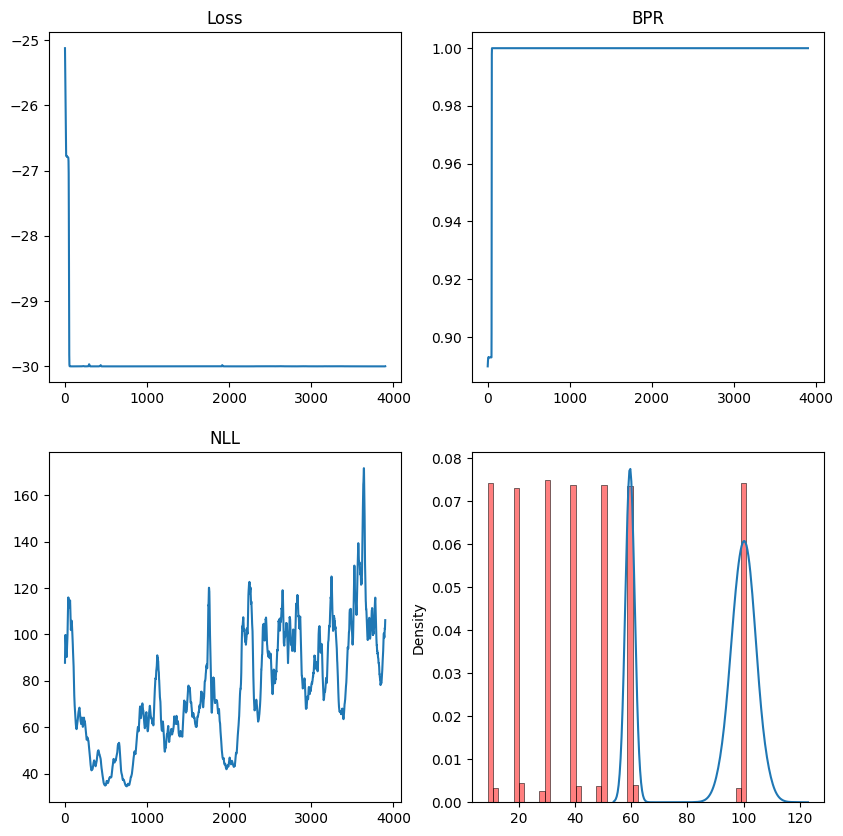

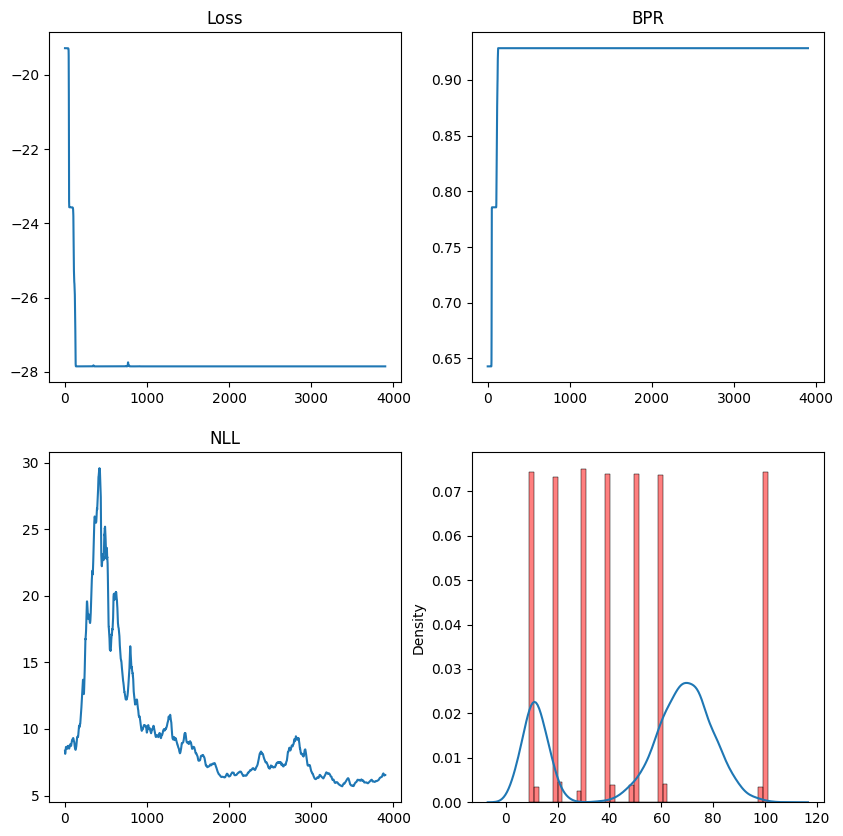

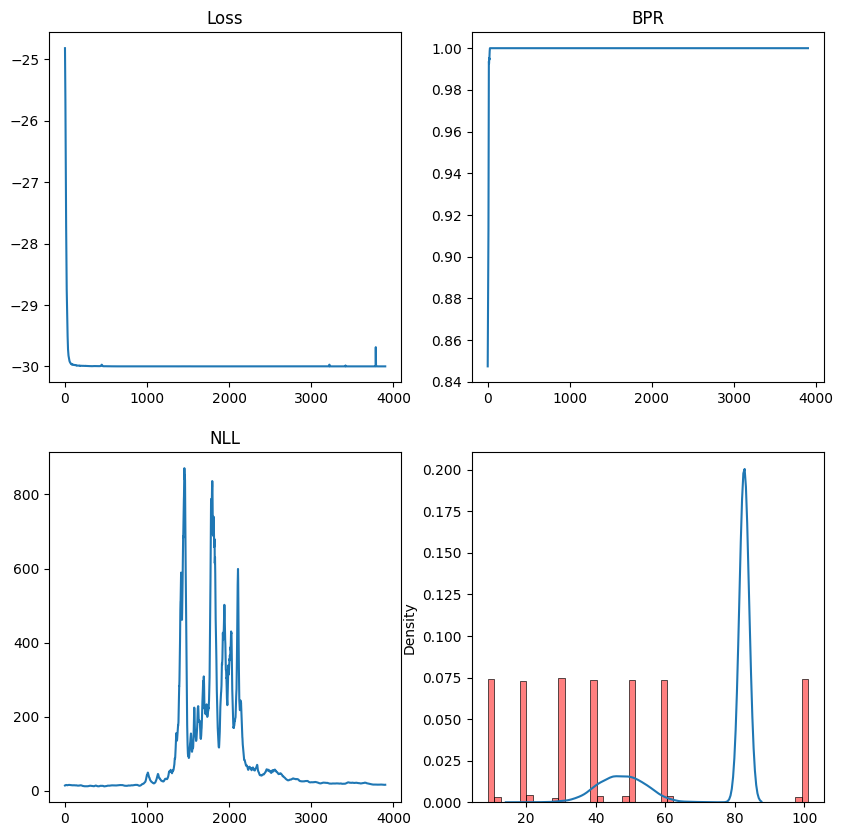

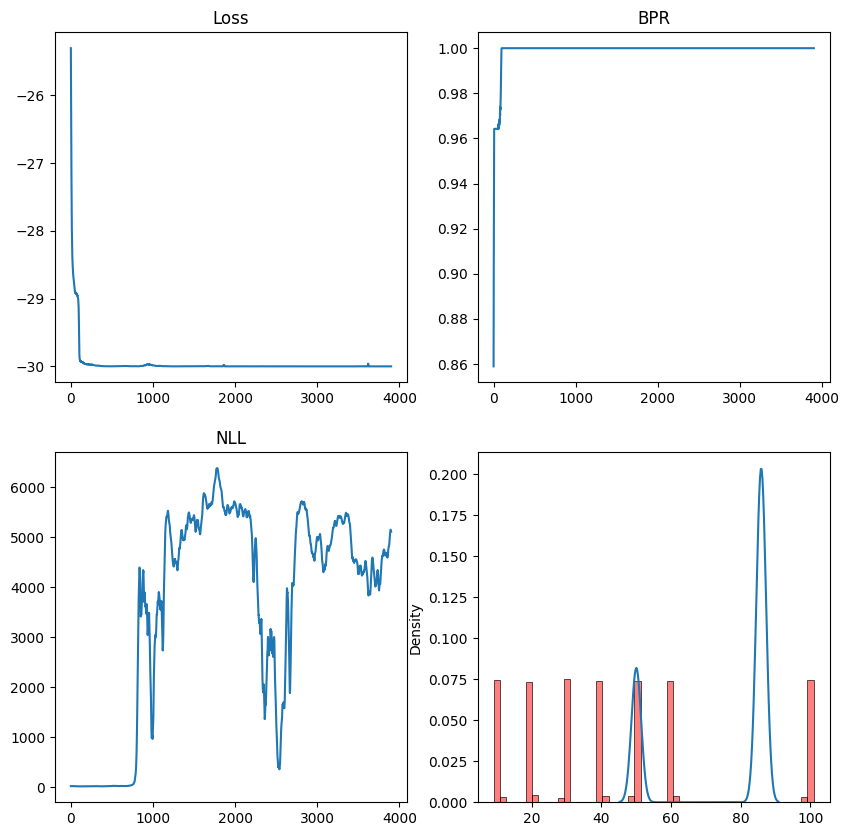

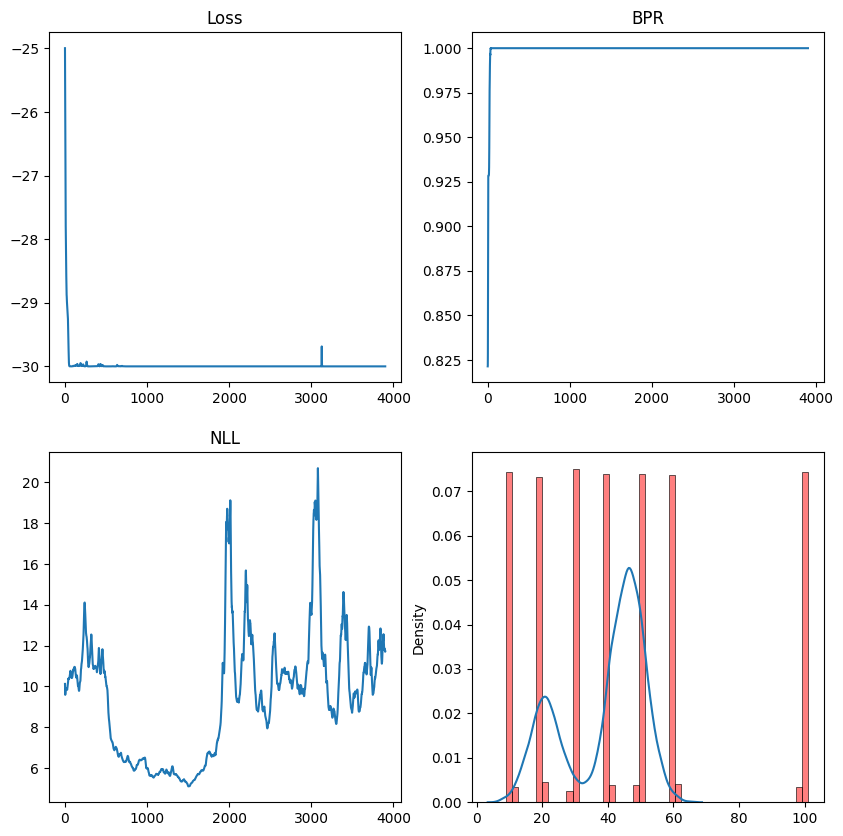

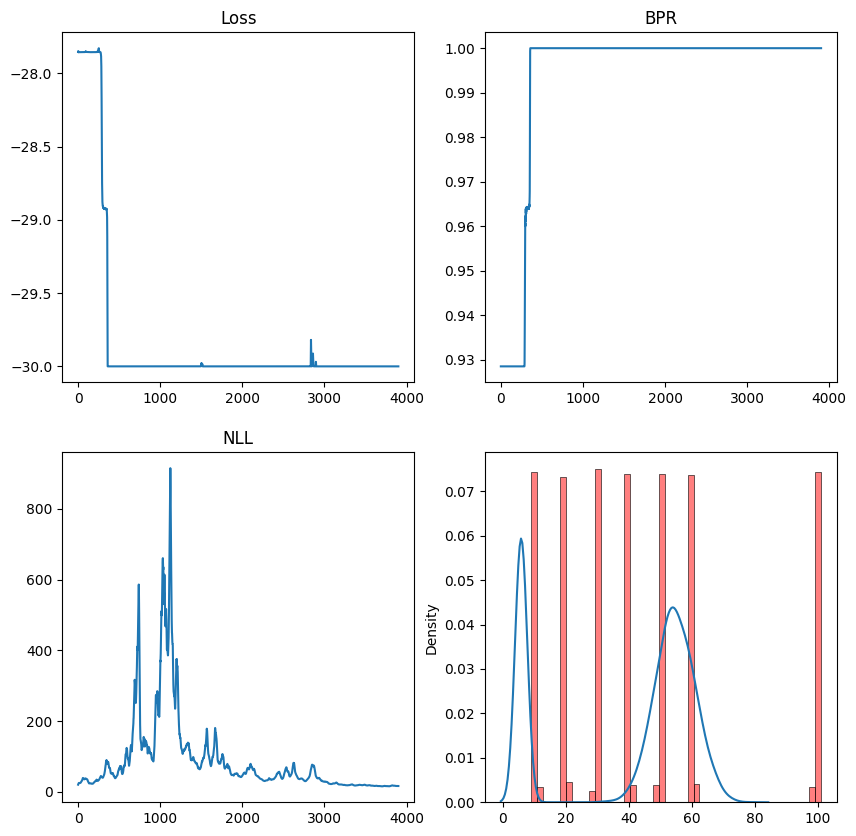

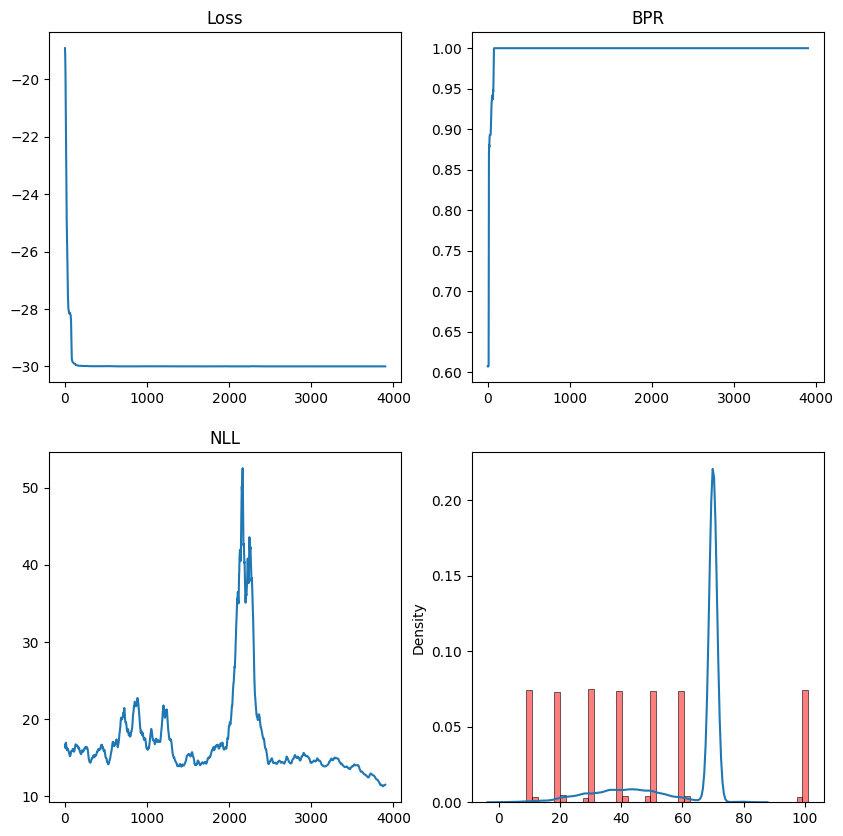

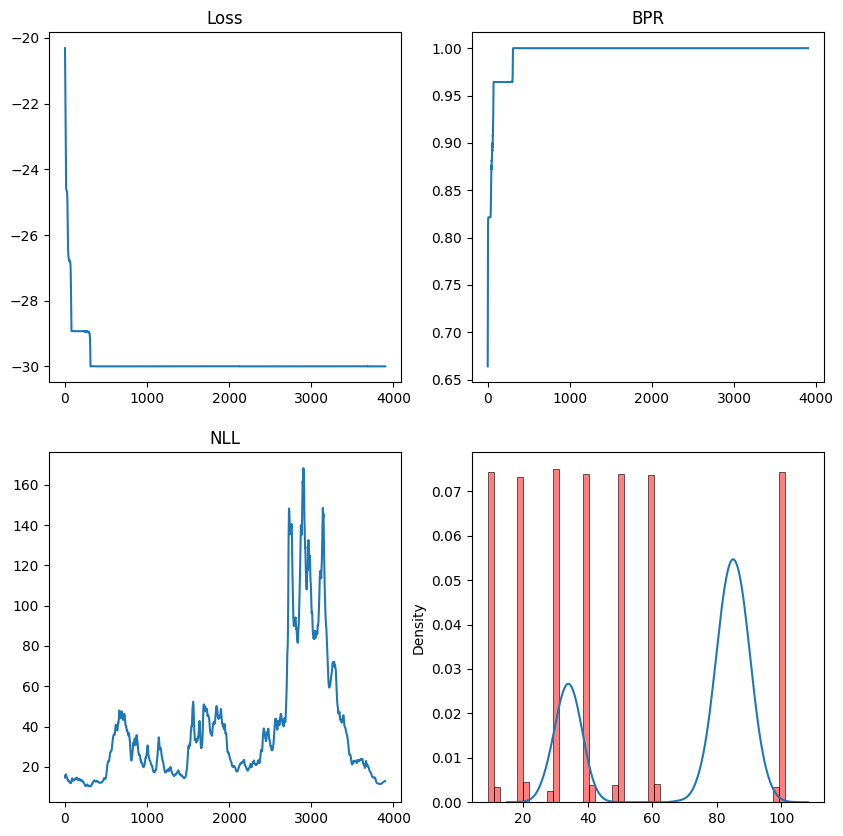

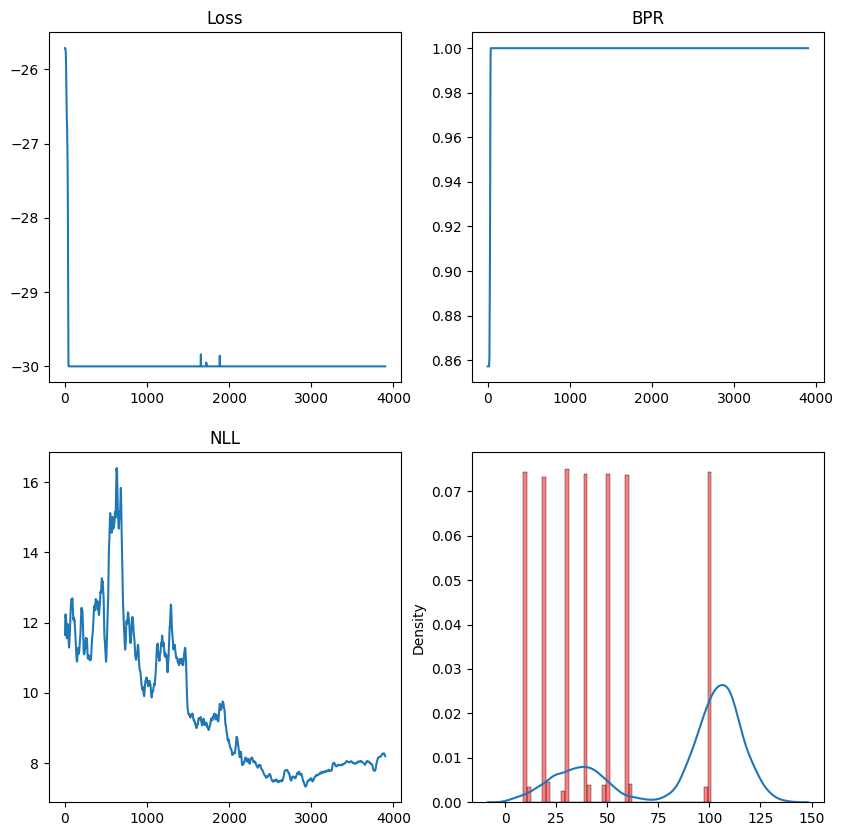

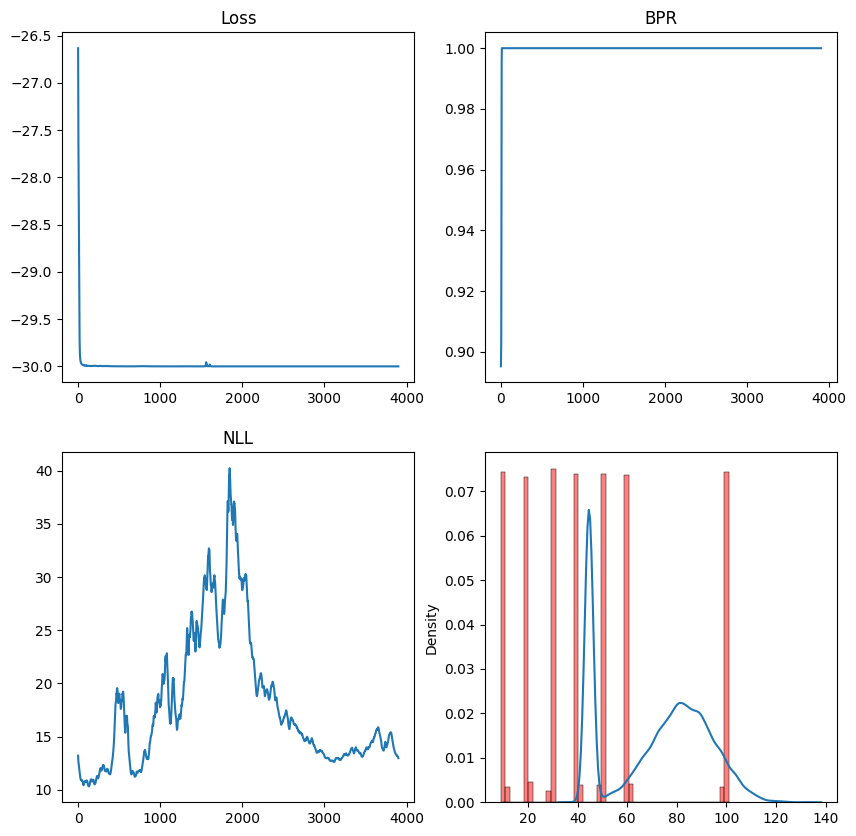

Processing 30 / 260


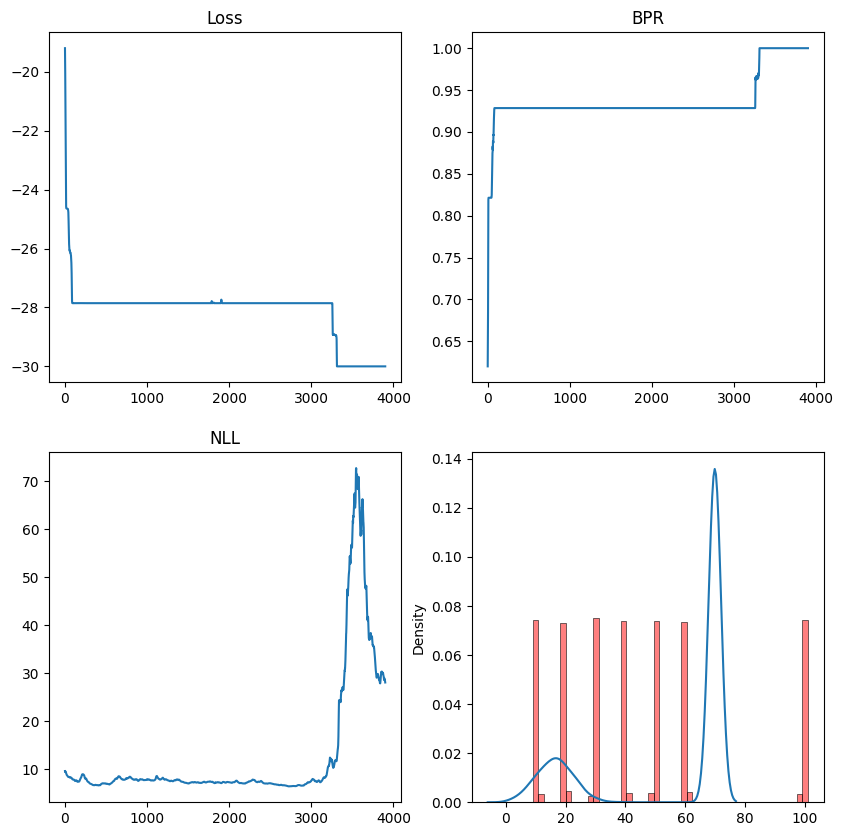

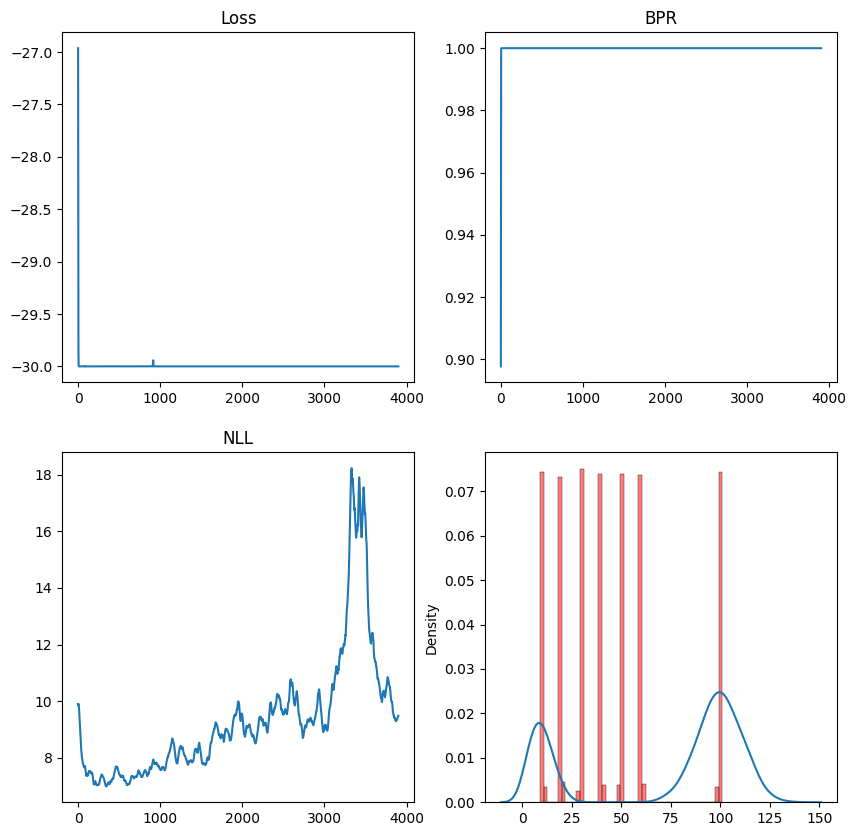

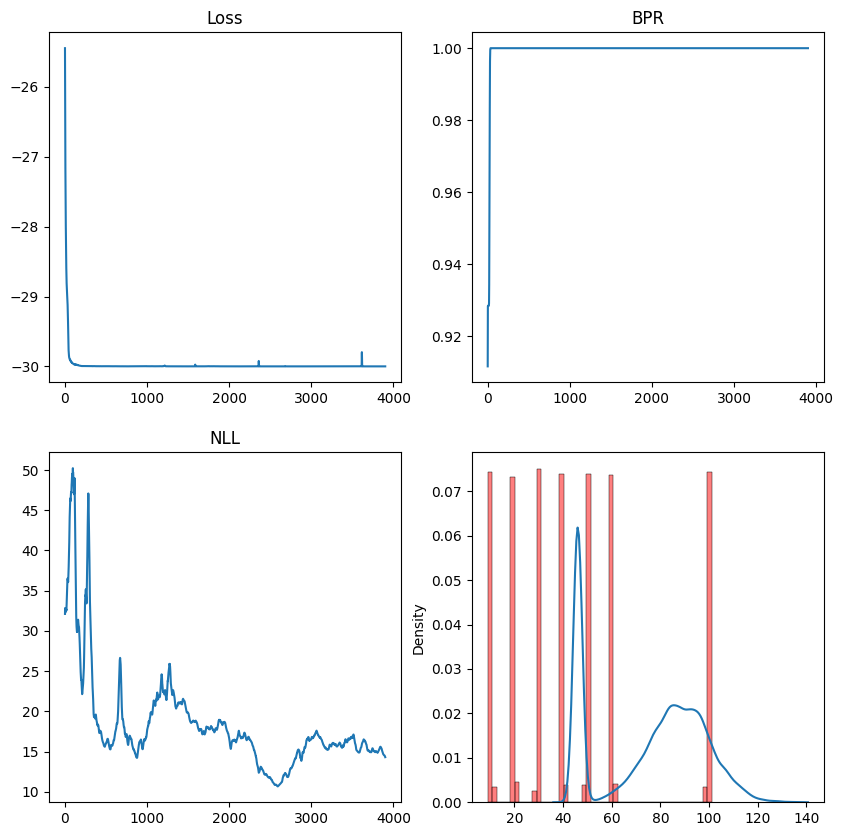

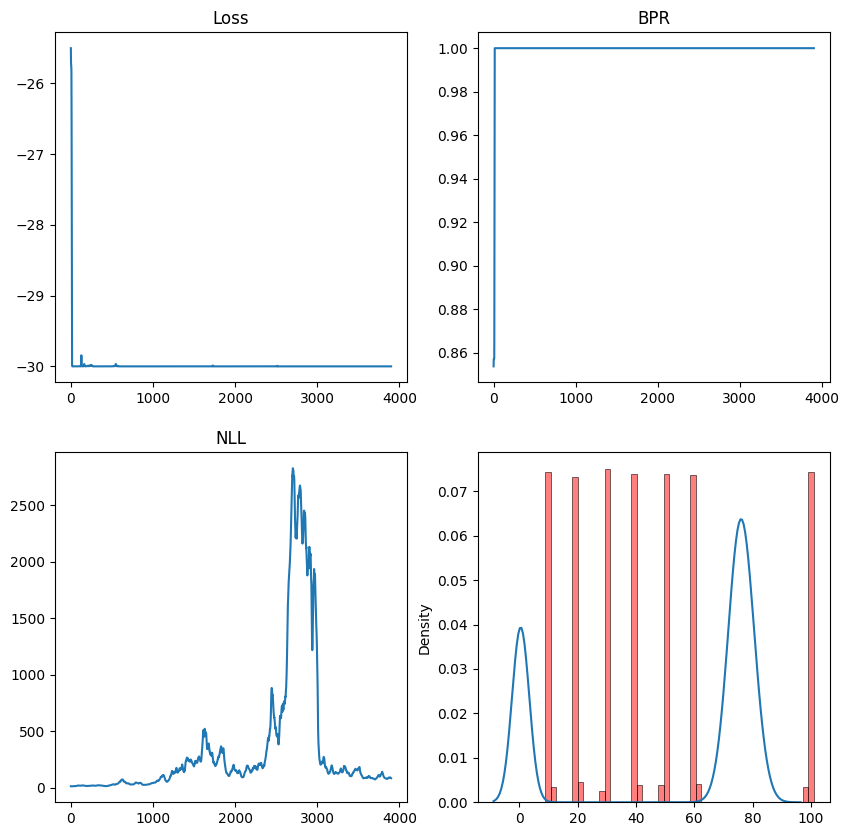

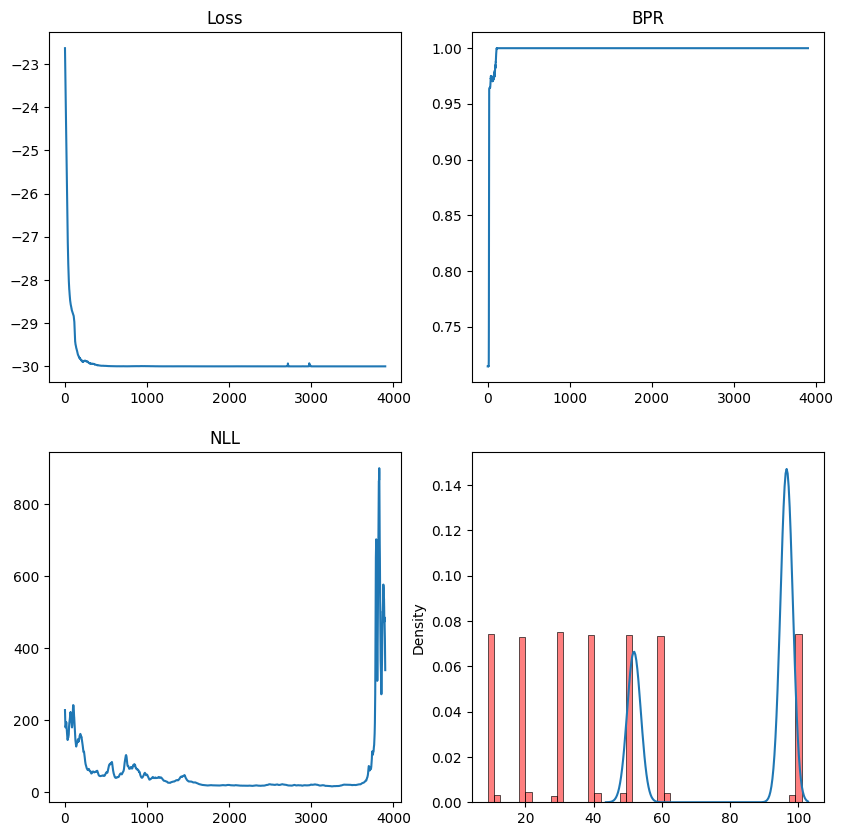

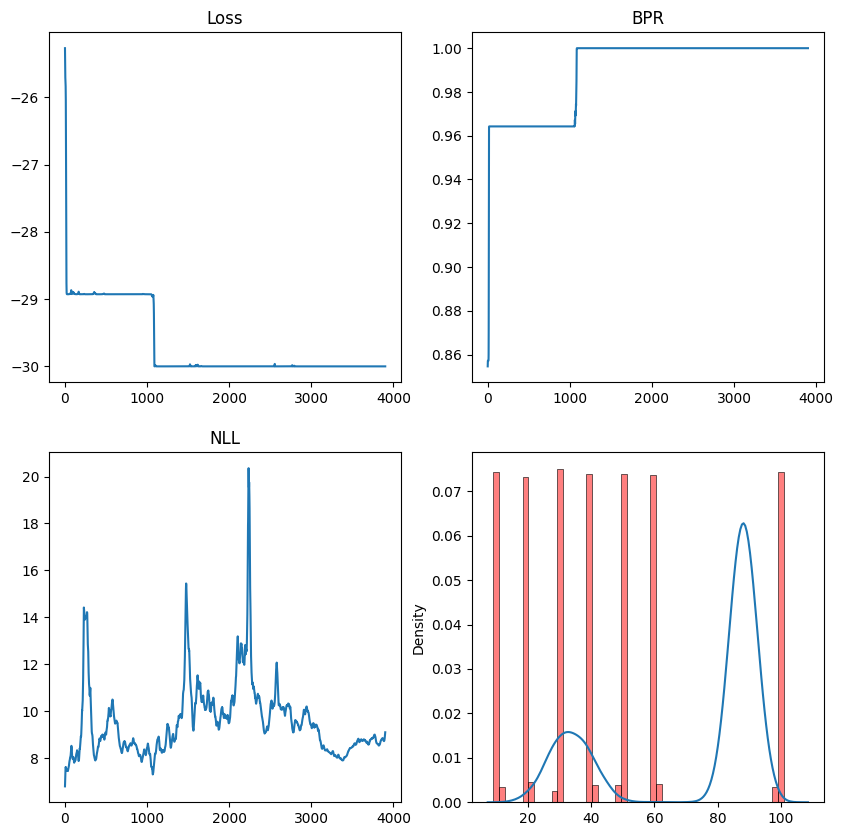

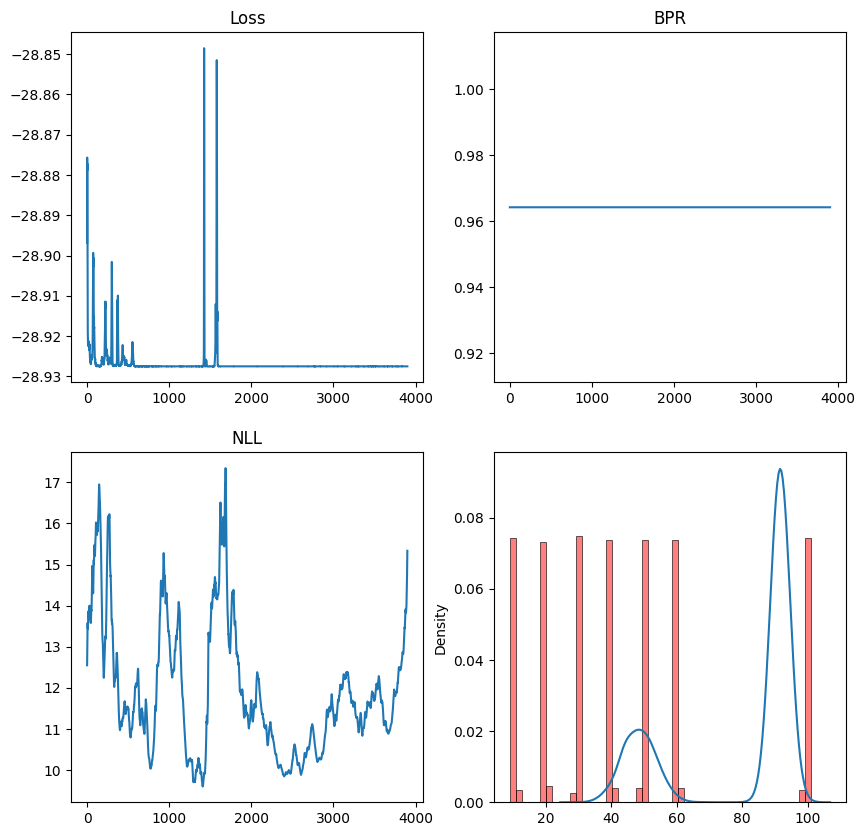

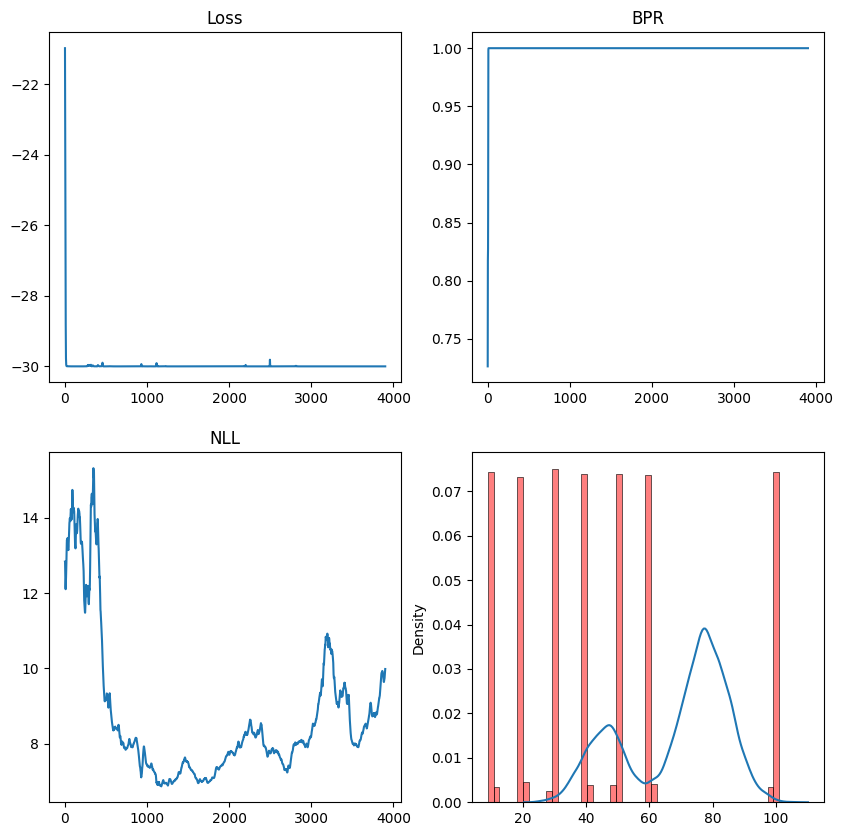

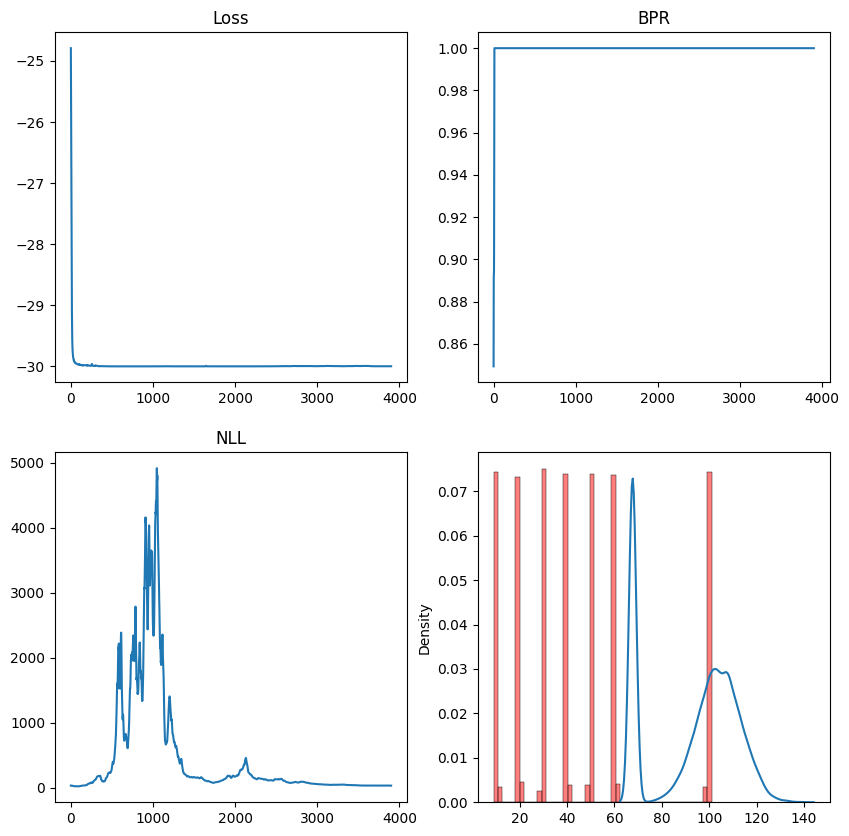

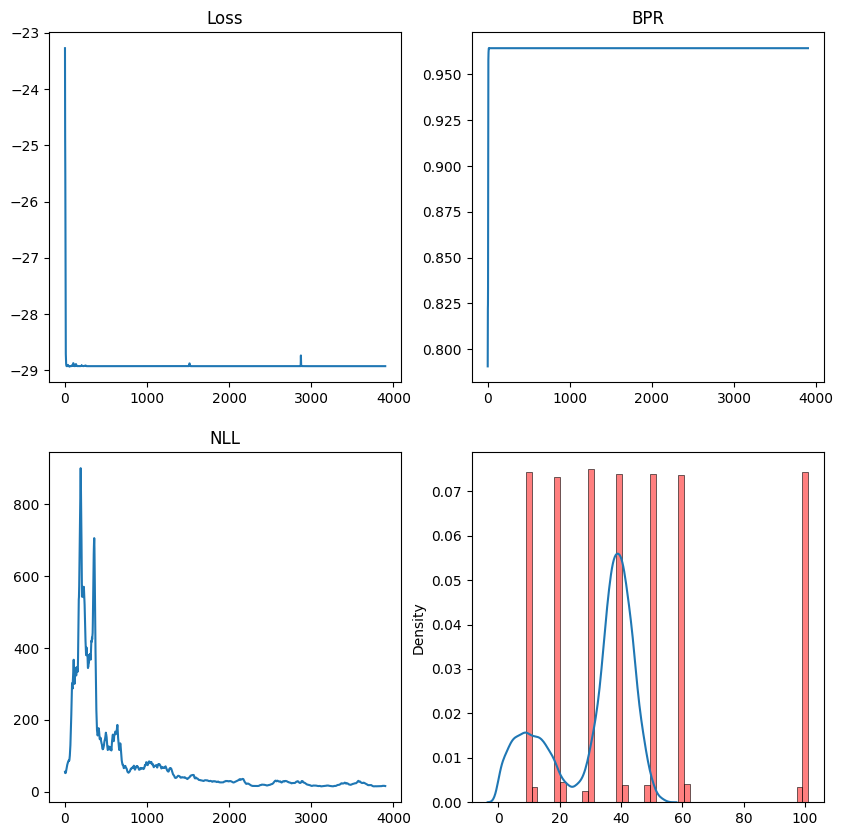

Processing 40 / 260


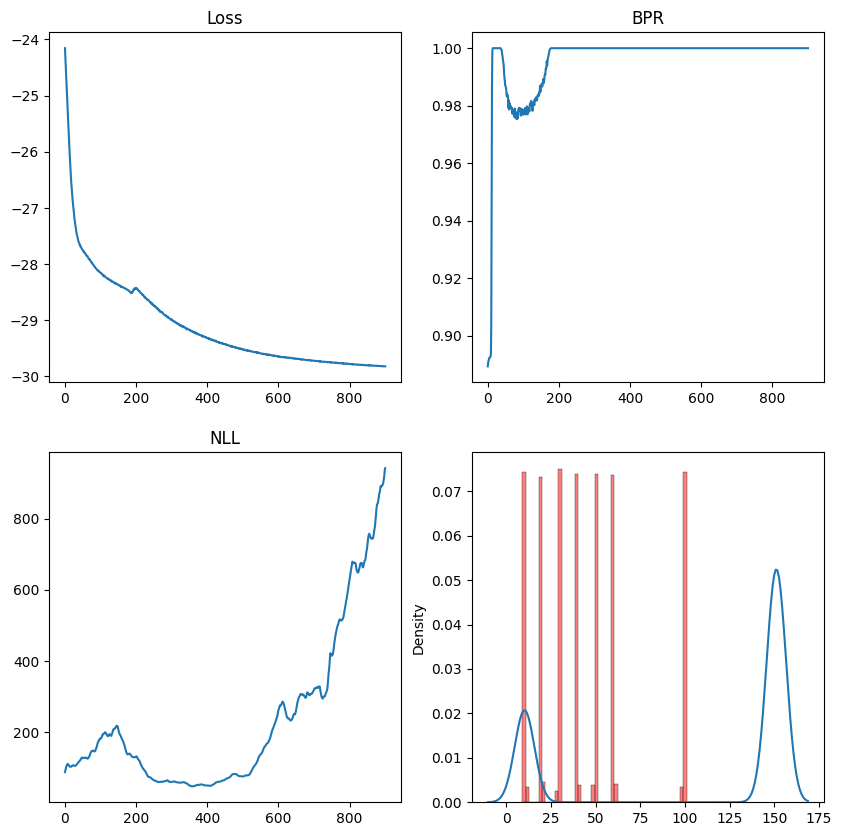

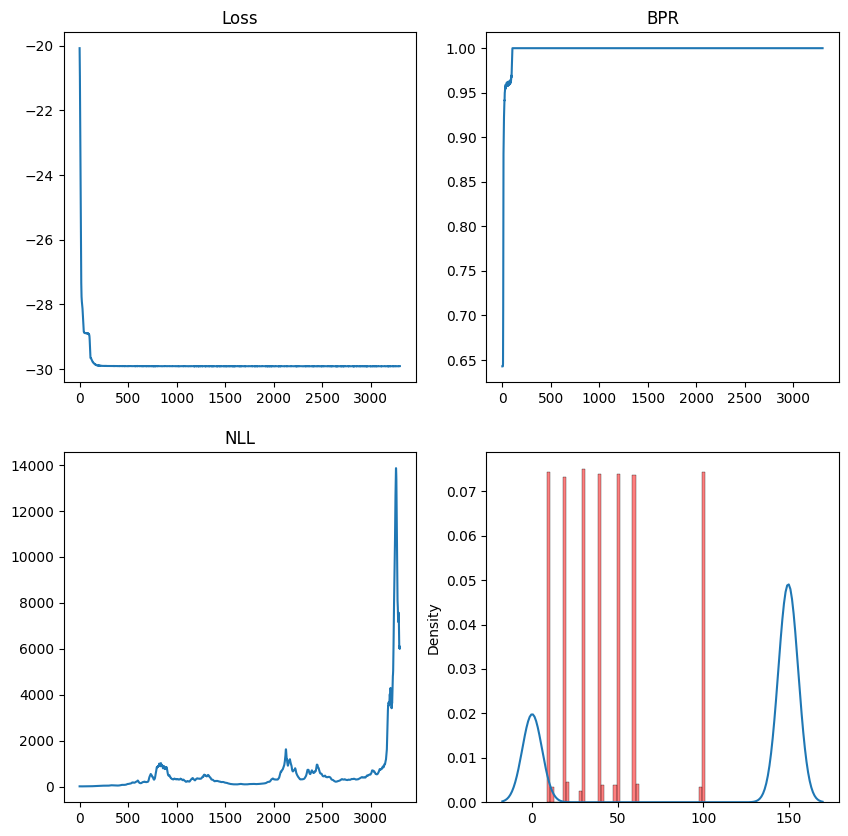

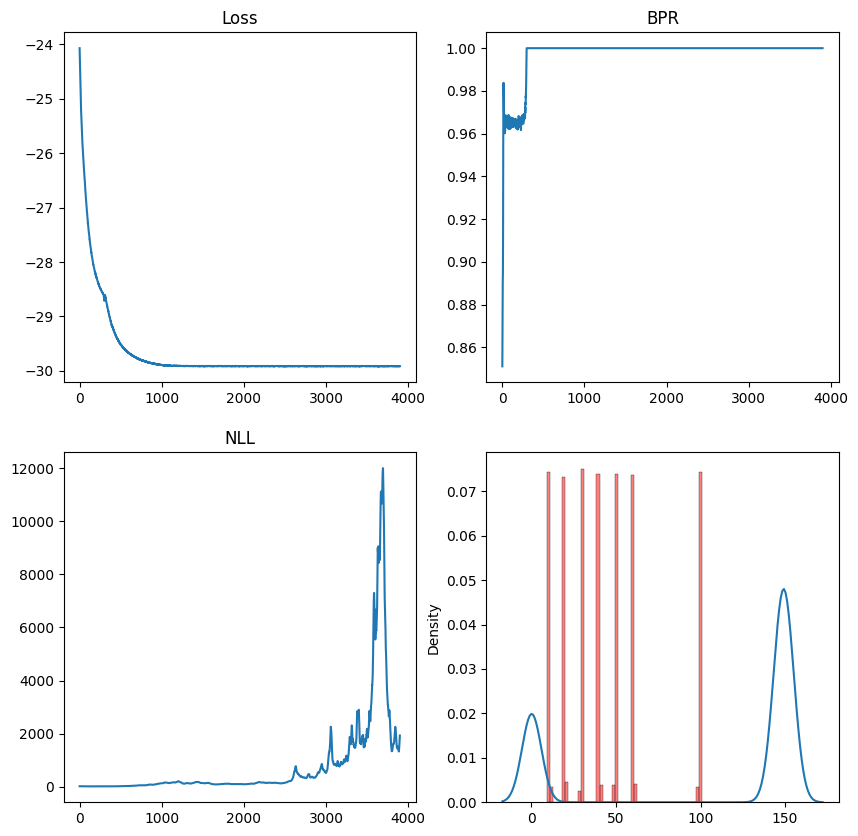

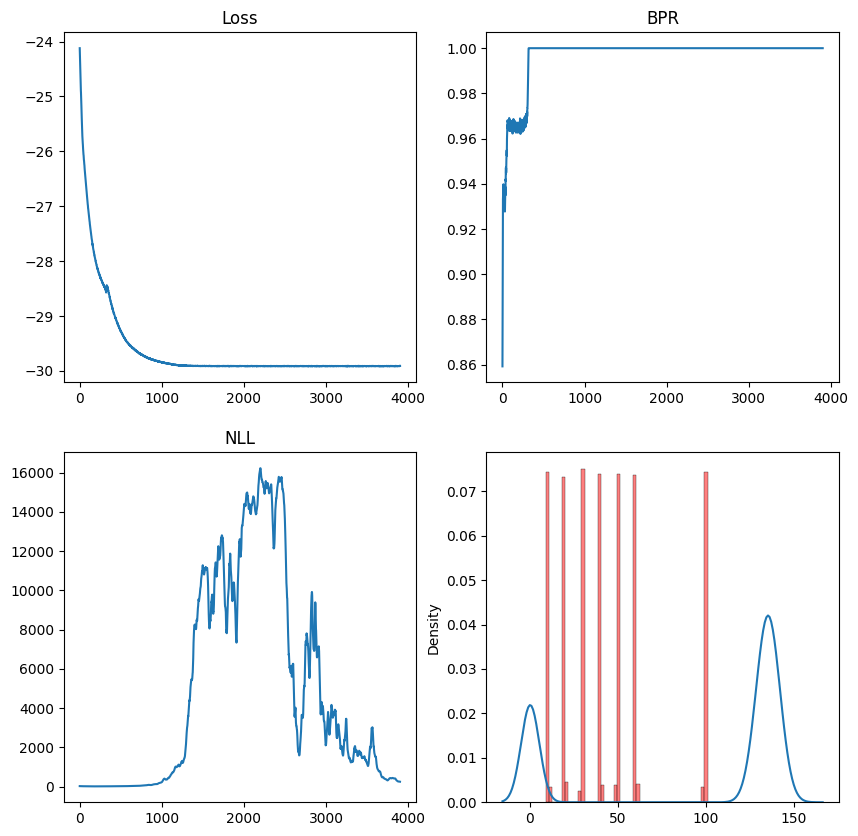

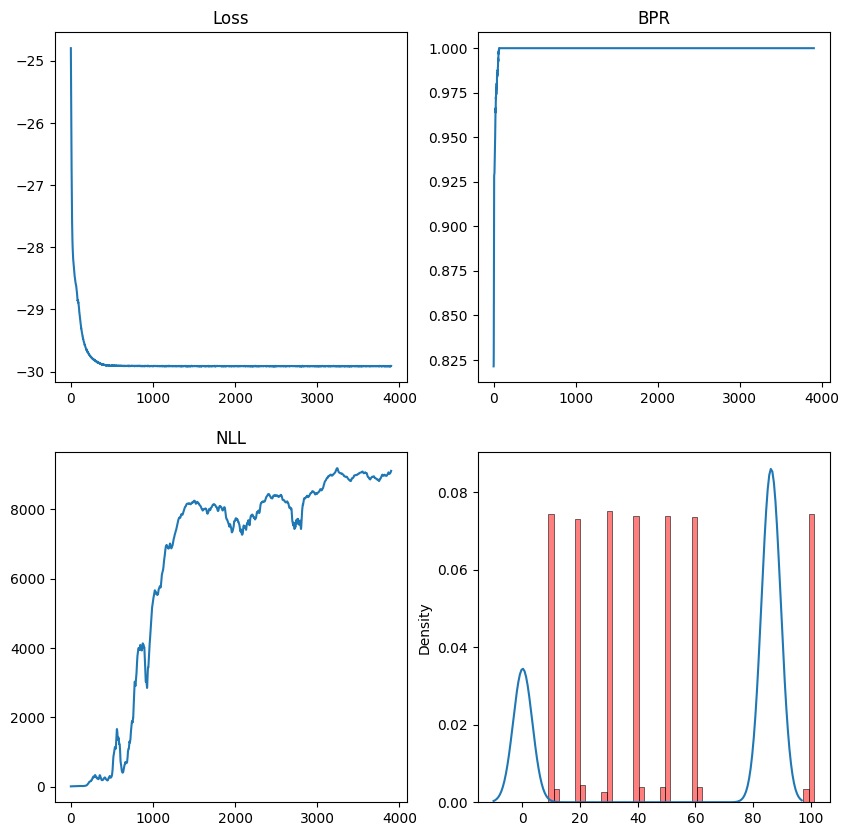

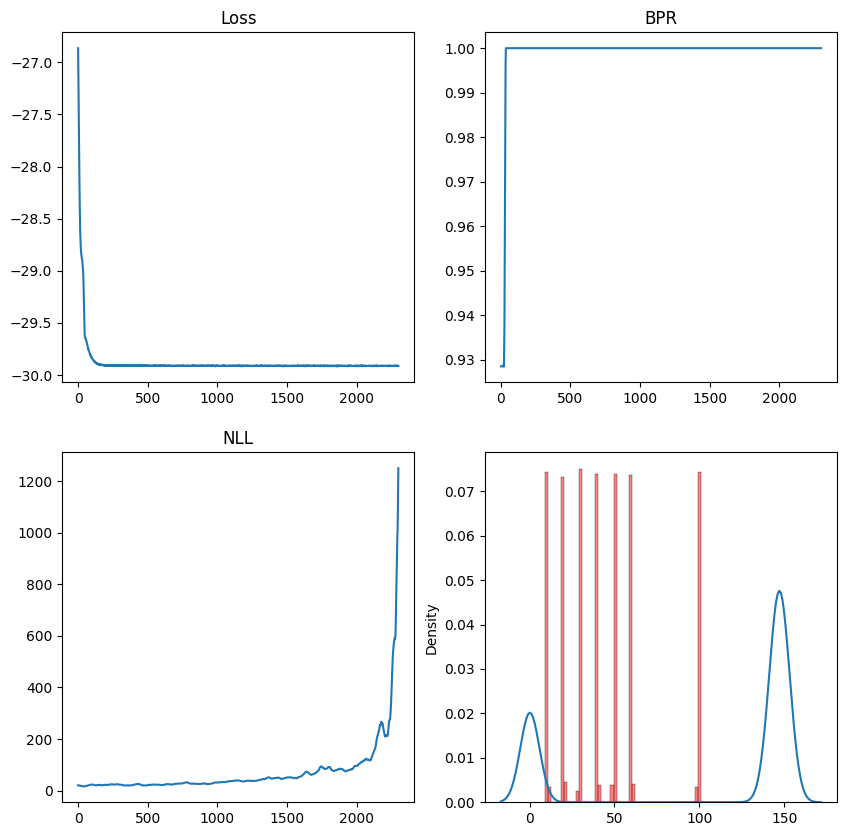

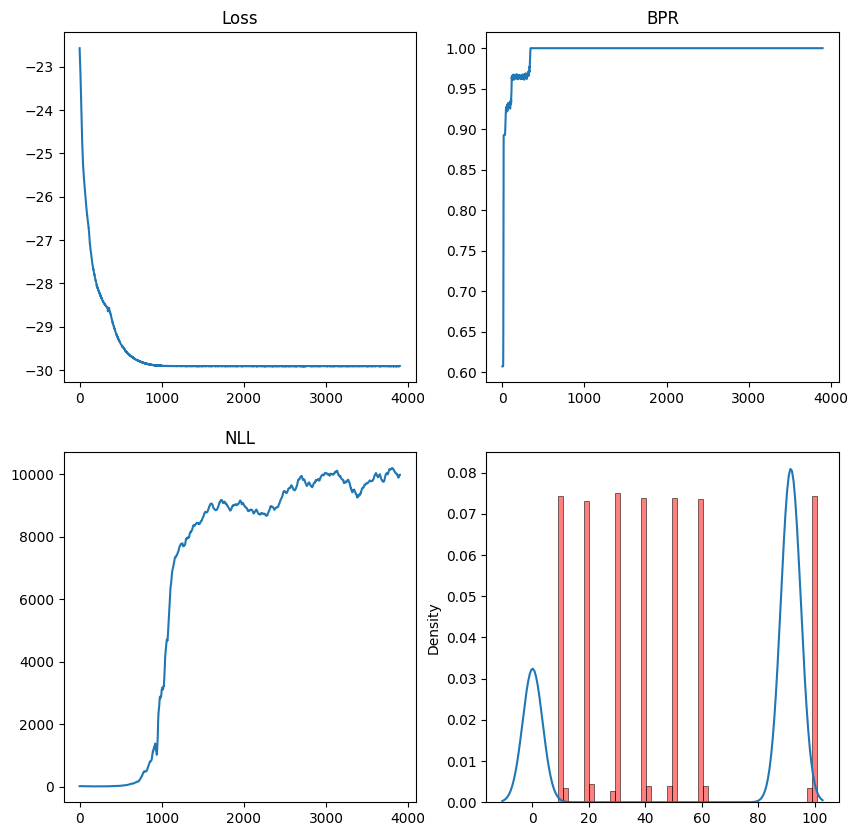

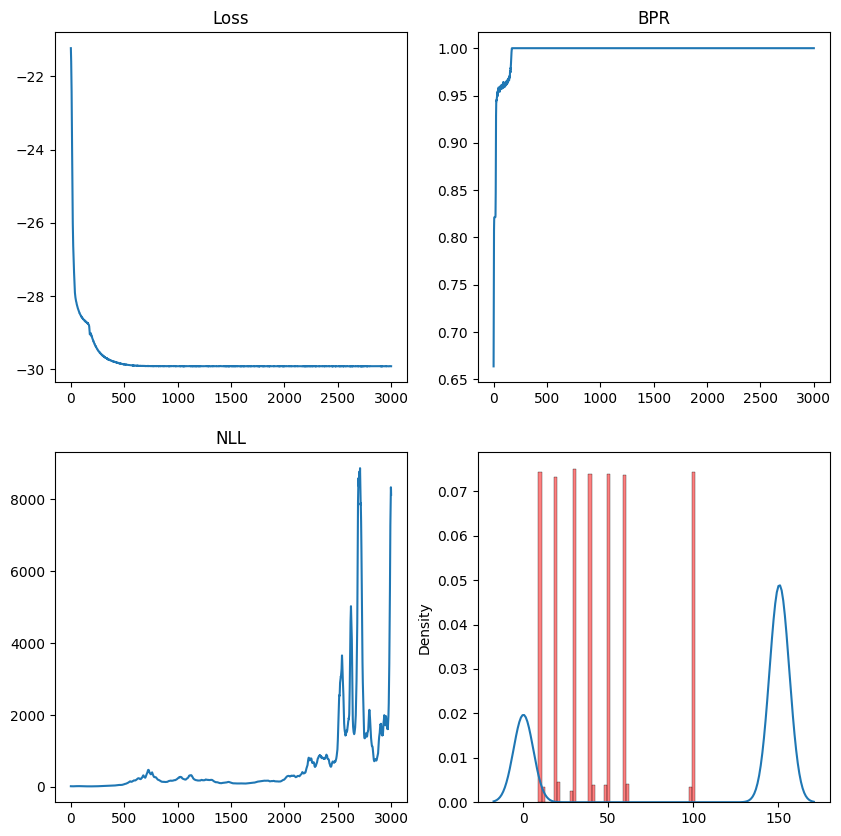

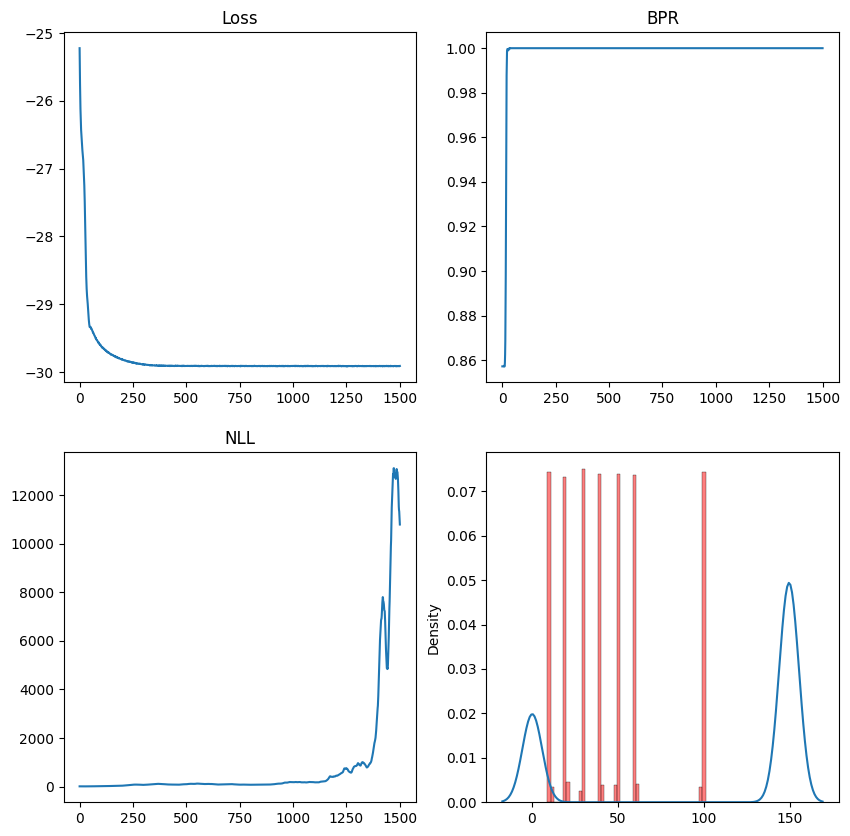

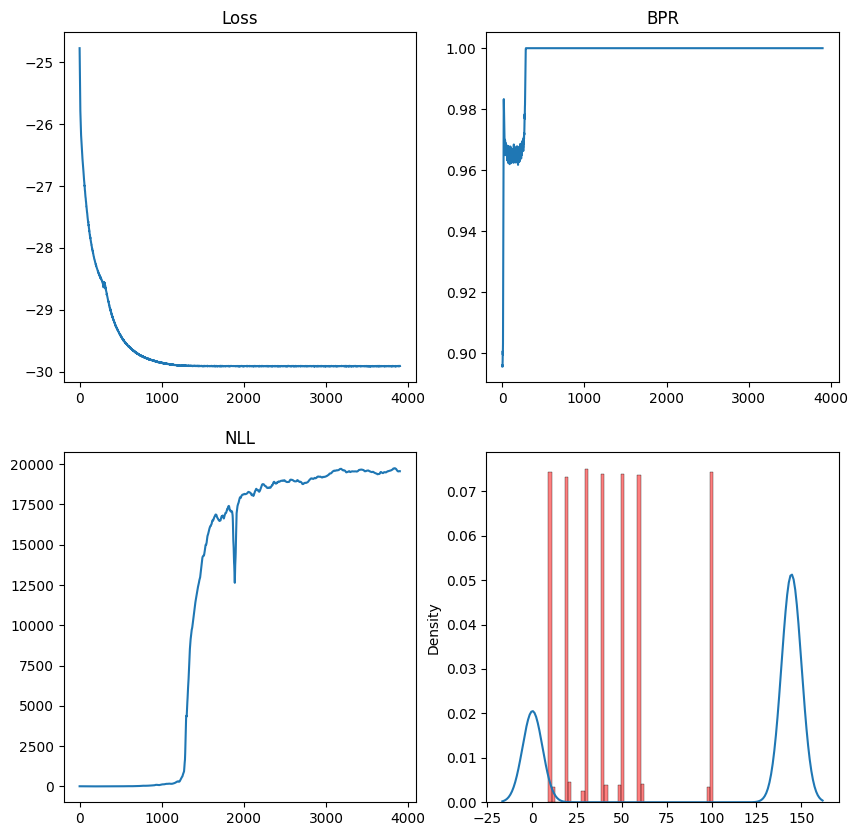

Processing 50 / 260


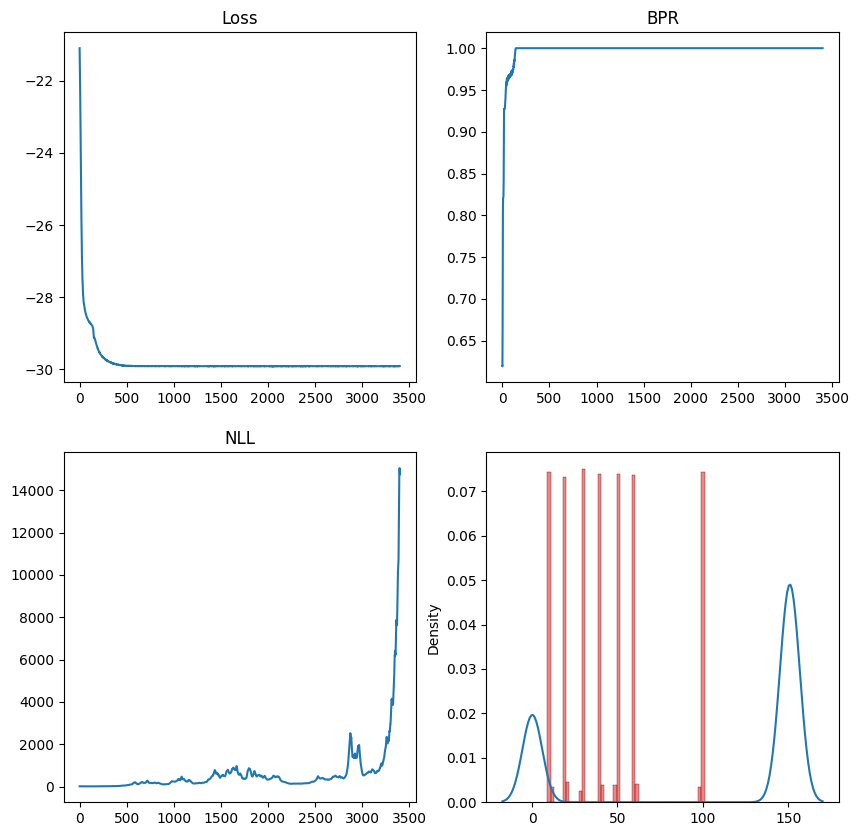

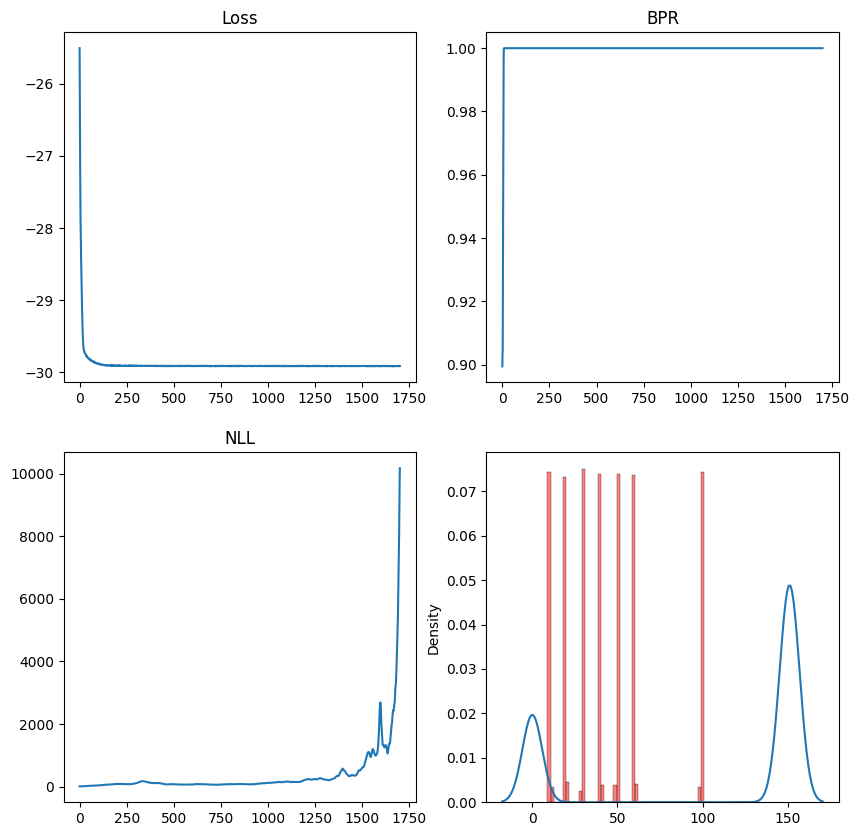

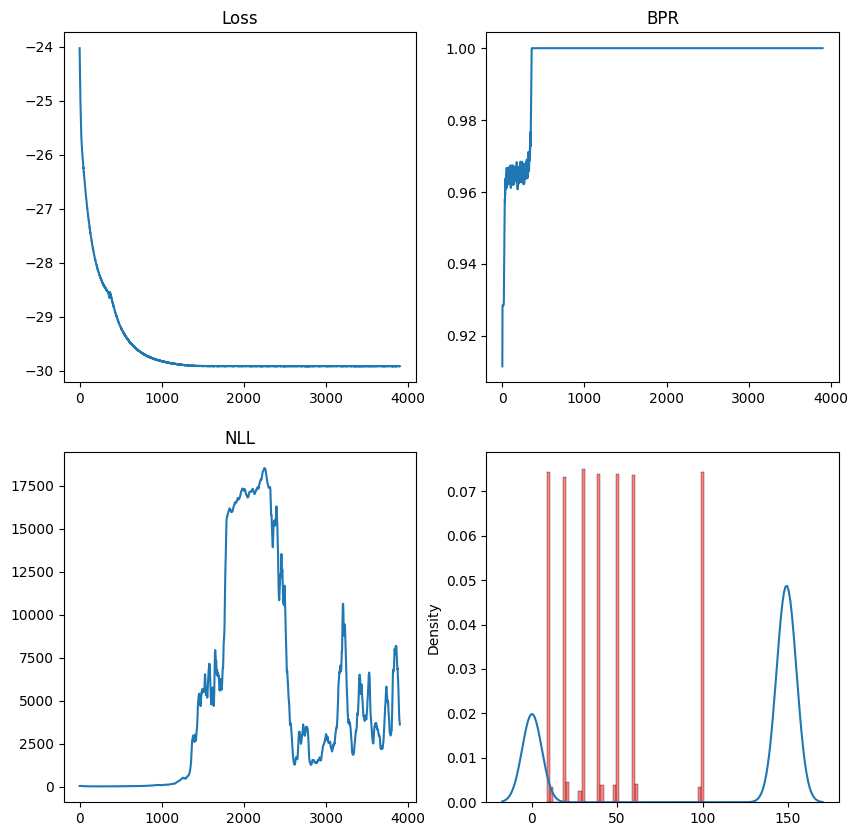

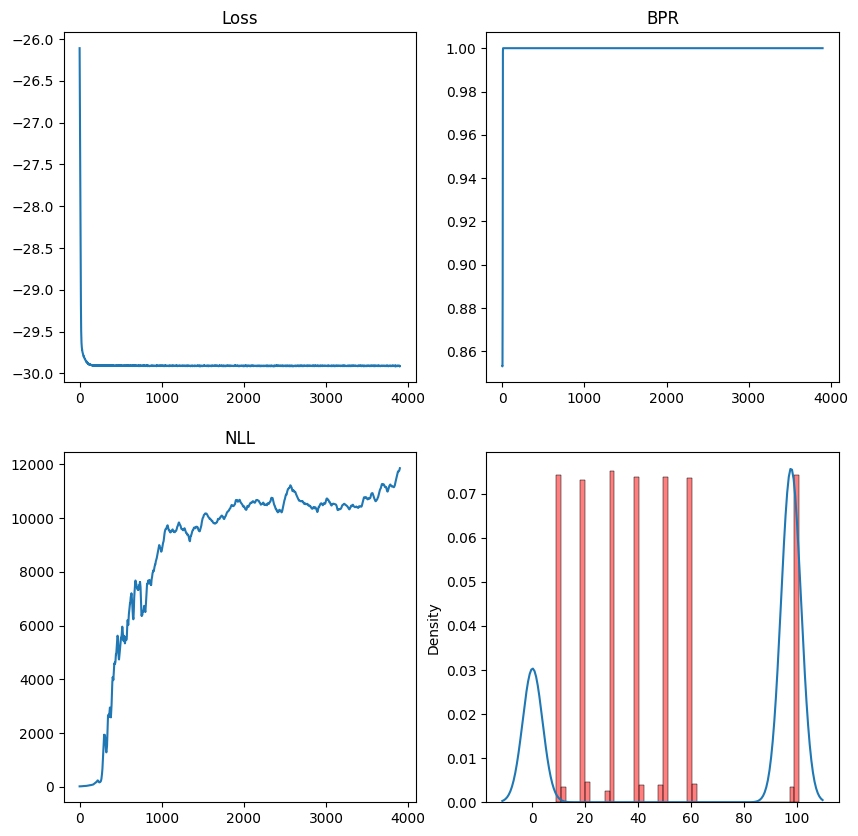

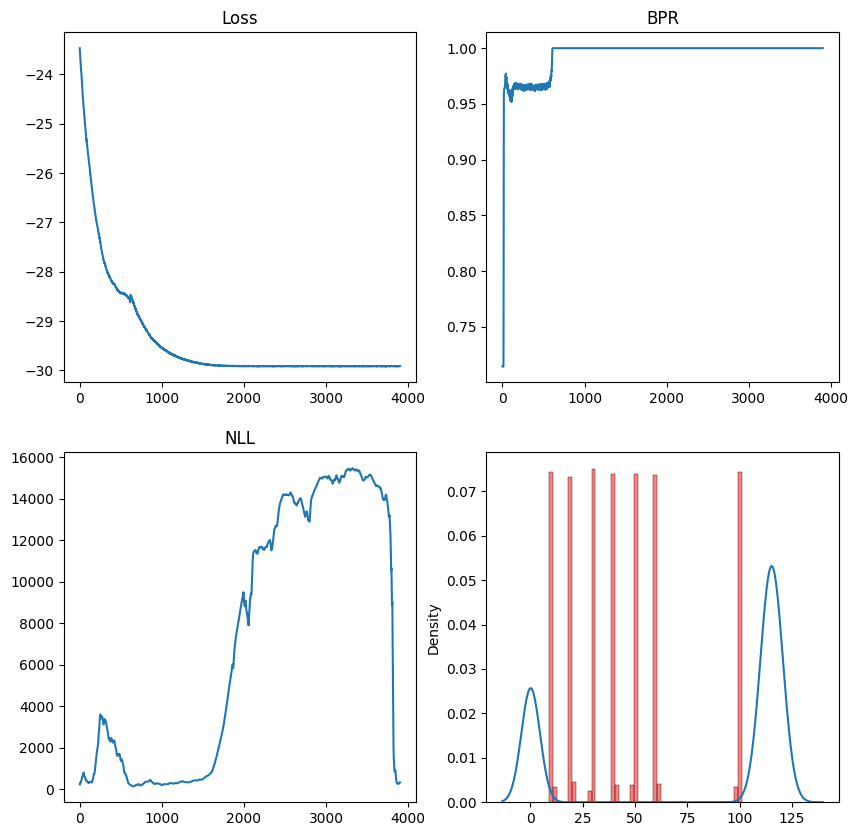

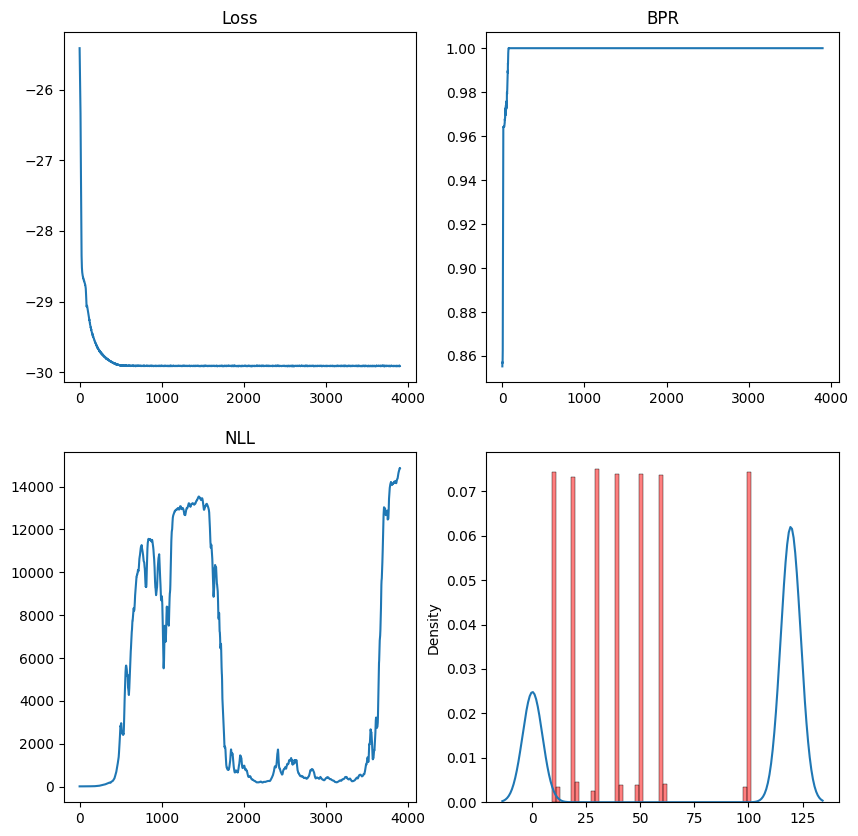

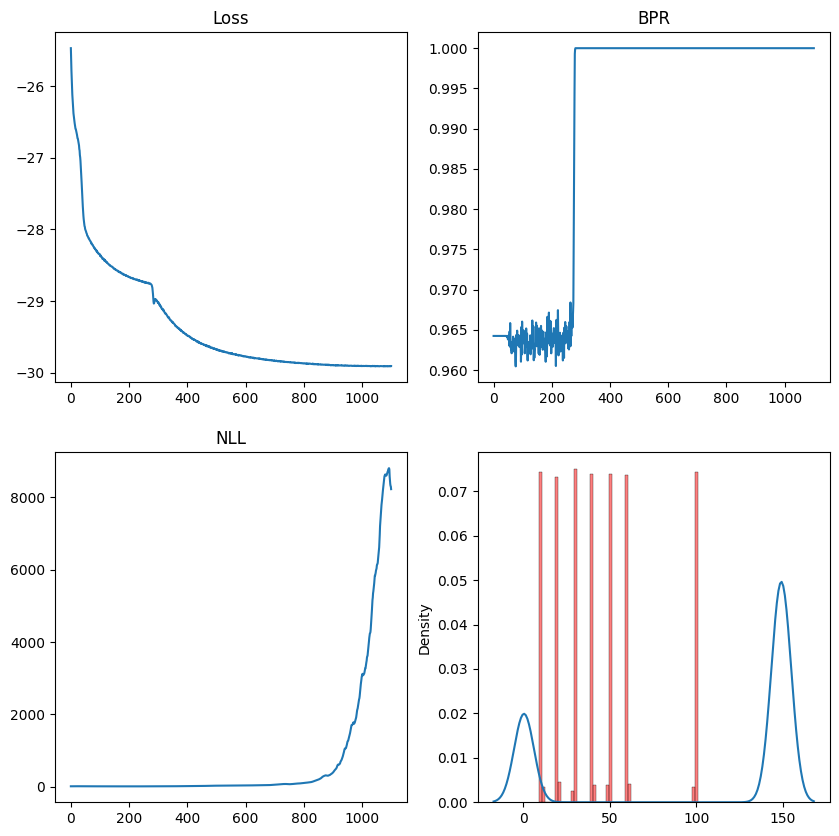

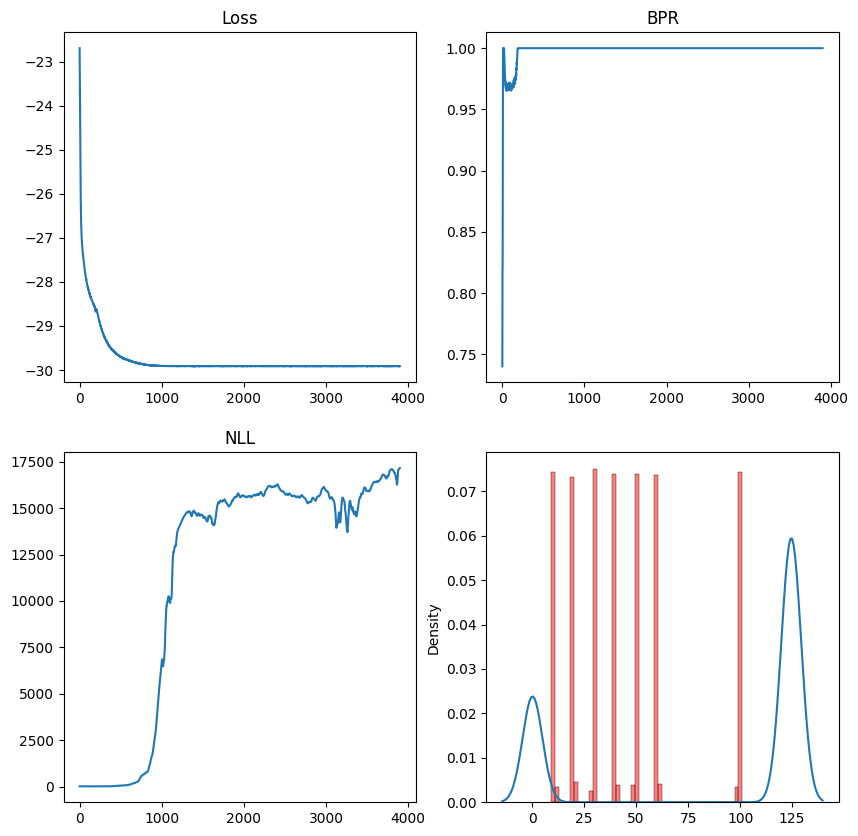

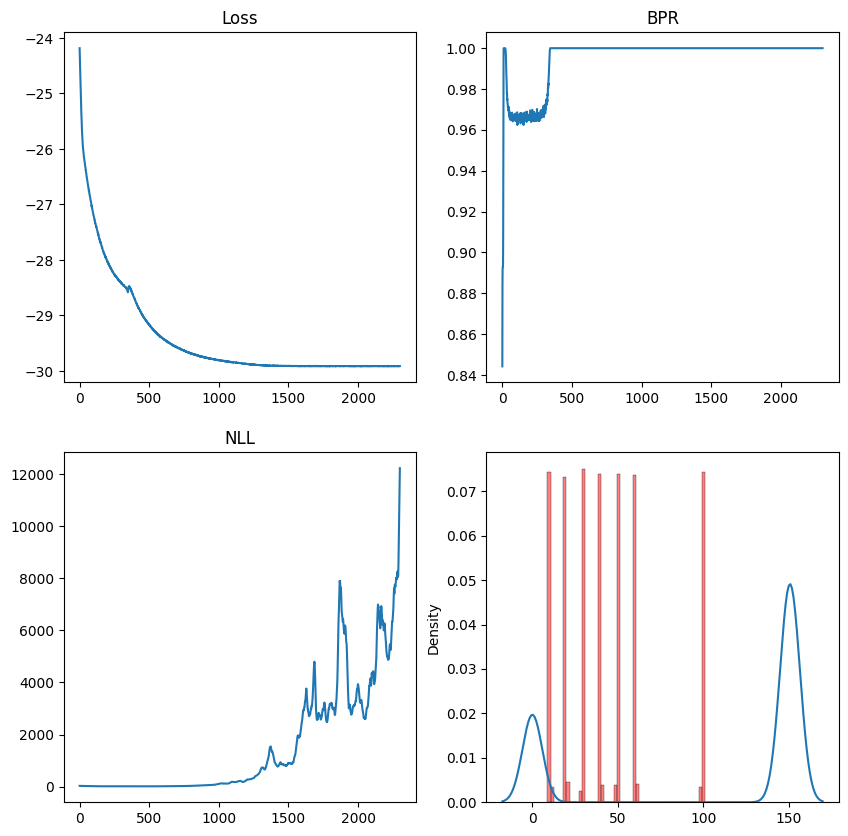

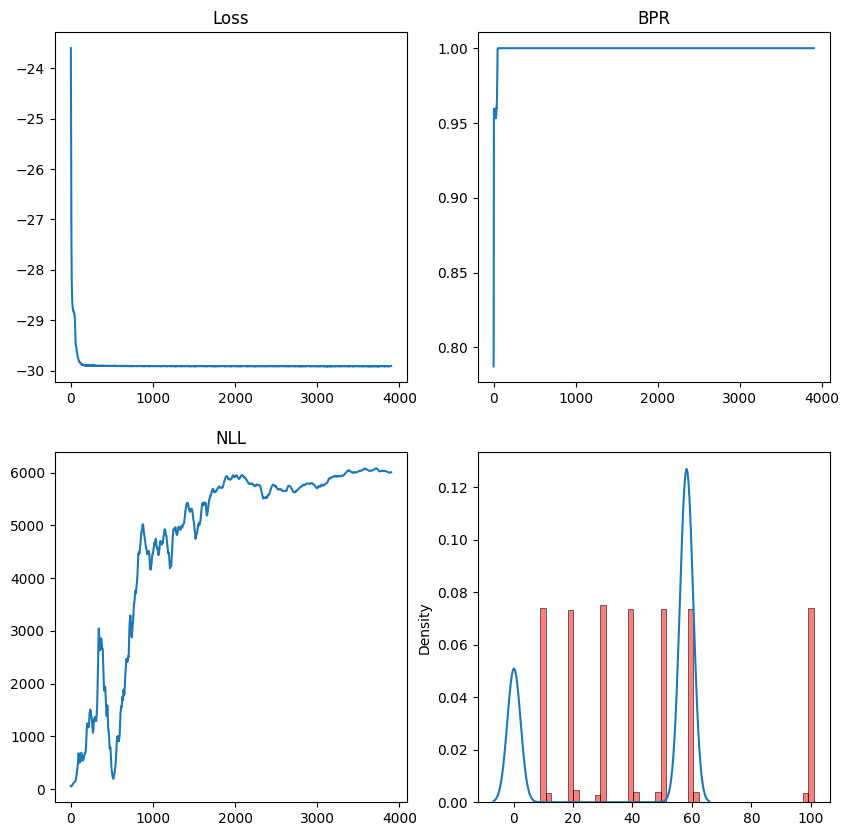

In [12]:
for e,exp in enumerate(exps):
    if 'nw0' not in exp:
        continue
    if e % 10 == 0:
        print(f'Processing {e} / {len(exps)}')

    # extract bw number and new number from model name
    bw = exp.split('bw')[1].split('_')[0]
    nw = exp.split('nw')[1].split('_')[0]
    title = f'BPR Weight: {bw}, NLL Weight: {nw}'
    model = MixtureOfTruncNormModel(num_components=2, S=S)
    model = make_report(model, exp, train_y_TS, title=title)

In [23]:
both_exp_by_thresh[0.8]

defaultdict(str,
            {0: '/cluster/tufts/hugheslab/kheuto01/new_data_2000_comp2/bw30_nw1_ss0.1_sig0.05_tr0.8_init0',
             1: '/cluster/tufts/hugheslab/kheuto01/new_data_2000_comp2/bw30_nw1_ss0.1_sig0.01_tr0.8_init1',
             10: '/cluster/tufts/hugheslab/kheuto01/new_data_2000_comp2/bw30_nw1_ss0.1_sig0.05_tr0.8_init10',
             11: '/cluster/tufts/hugheslab/kheuto01/new_data_2000_comp2/bw30_nw1_ss0.1_sig0.01_tr0.8_init11',
             12: '/cluster/tufts/hugheslab/kheuto01/new_data_2000_comp2/bw30_nw1_ss0.1_sig0.05_tr0.8_init12',
             13: '/cluster/tufts/hugheslab/kheuto01/new_data_2000_comp2/bw30_nw1_ss0.1_sig0.01_tr0.8_init13',
             14: '/cluster/tufts/hugheslab/kheuto01/new_data_2000_comp2/bw30_nw1_ss0.1_sig0.05_tr0.8_init14',
             15: '/cluster/tufts/hugheslab/kheuto01/new_data_2000_comp2/bw30_nw1_ss0.1_sig0.05_tr0.8_init15',
             16: '/cluster/tufts/hugheslab/kheuto01/new_data_2000_comp2/bw30_nw1_ss0.1_sig0.05_tr0.8_init16

In [ ]:
model.plot_learned(train_y_TS)

In [ ]:
model.plot_learned(train_y_TS)

In [ ]:
# bw500_nw0_ss0.001_th0.55
M_score_func =  200
M_action = 200
val_T = val_y_TS.shape[0]
mix_model = model()
bpr_nll = torch.sum(-mix_model.log_prob( torch.tensor(val_y_TS)))
y_sample_TMS = mix_model.sample((val_T, M_score_func))
y_sample_action_TMS = mix_model.sample((val_T, M_action))

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(val_y_TS), K=K)
bpr_det_bpr =torch.mean(deterministic_bpr_T)

In [ ]:
# bw0_nw1_ss0.1_th0.55
M_score_func =  200
M_action = 200
val_T = val_y_TS.shape[0]
mix_model = model()
nll_nll = torch.sum(-mix_model.log_prob( torch.tensor(val_y_TS)))
y_sample_TMS = mix_model.sample((val_T, M_score_func))
y_sample_action_TMS = mix_model.sample((val_T, M_action))

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(val_y_TS), K=K)
nll_det_bpr =torch.mean(deterministic_bpr_T)

In [ ]:
#bw5000_nw1_ss0.1_th0.55
M_score_func =  200
M_action = 200
val_T = val_y_TS.shape[0]
mix_model = model()
comb_nll = torch.sum(-mix_model.log_prob( torch.tensor(val_y_TS)))
y_sample_TMS = mix_model.sample((val_T, M_score_func))
y_sample_action_TMS = mix_model.sample((val_T, M_action))

ratio_rating_TMS = y_sample_action_TMS/y_sample_action_TMS.sum(dim=-1, keepdim=True)
ratio_rating_TS =  ratio_rating_TMS.mean(dim=1)
deterministic_bpr_T = deterministic_bpr(ratio_rating_TS, torch.tensor(val_y_TS), K=K)
comb_det_bpr =torch.mean(deterministic_bpr_T)

In [ ]:
plt.plot([comb_det_bpr.detach()], [-comb_nll.detach()], 'ko', label='Optimize Both')
plt.plot([nll_det_bpr.detach()], [-nll_nll.detach()], 'bo', label='Optimize NLL')
plt.plot([bpr_det_bpr.detach()], [-bpr_nll.detach()], 'go', label='Optimize BPR')
plt.legend()
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')

In [12]:
exps[-1]

'/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_nw1_ss0.5_sig0.05_tr1_init9'

In [16]:
exp.split('_tr')[-1]

'/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw0_nw1_ss0.1_init0'

(-10.0, -3.655332853872567)

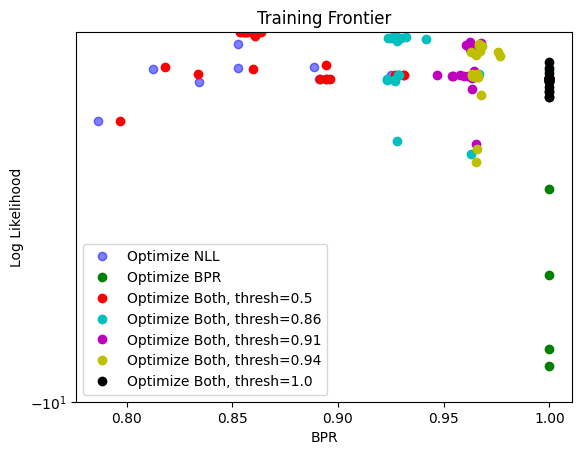

In [5]:
nll_bprs = []
nll_nlls = []
nll_bprs_by_init = collections.defaultdict(lambda: -np.inf)
nll_nlls_by_init = collections.defaultdict(lambda: -np.inf)
nll_exp_by_init = collections.defaultdict(str)
bpr_bprs = []
bpr_nlls = []
bpr_bprs_by_init = collections.defaultdict(lambda: -np.inf)
bpr_nlls_by_init = collections.defaultdict(lambda: -np.inf)
bpr_exp_by_init = collections.defaultdict(str)
both_bprs = []
both_nlls = []
both_bprs_by_thresh = collections.defaultdict(lambda: collections.defaultdict(lambda: -np.inf))
both_nlls_by_thresh = collections.defaultdict(lambda: collections.defaultdict(lambda: -np.inf))
both_exp_by_thresh = collections.defaultdict(lambda: collections.defaultdict(str))
max_nll = -np.inf

for e,exp in enumerate(exps):
    losses = torch.load(exp + '/losses.pth')
    bprs = torch.load(exp + '/bprs.pth')
    nlls = torch.load(exp + '/nlls.pth')

    losses = np.array([loss.detach().numpy() for loss in losses])
    bprs = np.array([bpr.detach().numpy() for bpr in bprs])
    nlls = np.array([nll.detach().numpy() for nll in nlls])
    bw = exp.split('bw')[1].split('_')[0]
    nw = exp.split('nw')[1].split('_')[0]
    init = int(exp.split('init')[-1])
    if 'tr' in exp:
        thresh = float(exp.split('_tr')[-1].split('_')[0])
    else:
        thresh = 0

    bpr = bprs[-1]
    nll = -nlls[-1]
    if nll > max_nll:
        max_nll = nll


    if bw=='0':
        nll_bprs.append(bprs[-1])
        nll_nlls.append(-nlls[-1])
        if nll > nll_nlls_by_init[init]:
            nll_nlls_by_init[init] = nll
            nll_bprs_by_init[init] = bpr
            nll_exp_by_init[init] = exp
    elif nw=='0':
        bpr_bprs.append(bprs[-1])
        bpr_nlls.append(-nlls[-1])
        if bpr > bpr_bprs_by_init[init]:
            bpr_bprs_by_init[init] = bpr
            bpr_nlls_by_init[init] = nll
            bpr_exp_by_init[init] = exp
    else:
        both_bprs.append(bprs[-1])
        both_nlls.append(-nlls[-1])
        if bpr > both_bprs_by_thresh[thresh][init]:
            both_bprs_by_thresh[thresh][init] = bpr
            both_nlls_by_thresh[thresh][init] = nll
            both_exp_by_thresh[thresh][init] = exp

plt.plot(nll_bprs_by_init.values(), nll_nlls_by_init.values(), 'bo',alpha=0.5, label='Optimize NLL')
plt.plot(bpr_bprs_by_init.values(), bpr_nlls_by_init.values(), 'go', label='Optimize BPR')
# plot best of both with each thresh in a different color
colors = ['r', 'c', 'm', 'y', 'k']

for i, thresh in enumerate(both_bprs_by_thresh.keys()):
    plt.plot(both_bprs_by_thresh[thresh].values(), both_nlls_by_thresh[thresh].values(), f'{colors[i]}o', label=f'Optimize Both, thresh={thresh}')
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')
# set ylimits to -100000 to 0
#plt.ylim(-1100000, -1000)
# make y axis log scale even with negative values
plt.yscale('symlog', linthresh=1)
plt.title('Training Frontier')
plt.legend()
plt.ylim([-10, max_nll])
    

In [11]:
both_exp_by_thresh[1].values()

dict_values(['/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr1_init0', '/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr1_init1', '/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr1_init10', '/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr1_init11', '/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr1_init12', '/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr1_init13', '/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr1_init14', '/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr1_init15', '/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_nw1_ss0.1_sig0.01_tr1_init16', '/cluster/tufts/hugheslab/kheuto01/fixed_threshold_exp_4000_comp2/bw30_

(-10.0, -2.3982765305787894)

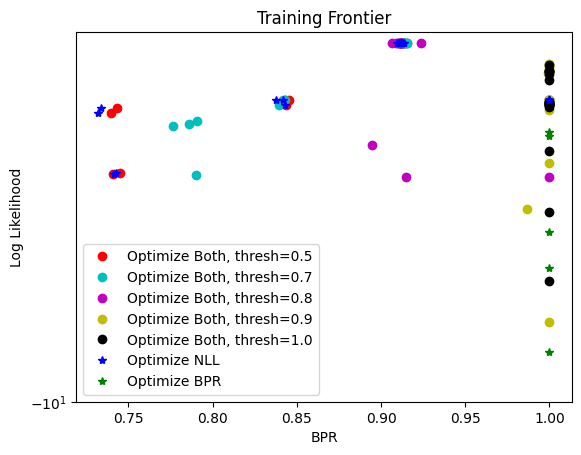

In [15]:

# plot best of both with each thresh in a different color
colors = ['r', 'c', 'm', 'y', 'k']
for i, thresh in enumerate(both_bprs_by_thresh.keys()):
    plt.plot(both_bprs_by_thresh[thresh].values(), both_nlls_by_thresh[thresh].values(), f'{colors[i]}o', label=f'Optimize Both, thresh={thresh}')
plt.plot(nll_bprs_by_init.values(), nll_nlls_by_init.values(), 'b*',alpha=1, label='Optimize NLL')
plt.plot(bpr_bprs_by_init.values(), bpr_nlls_by_init.values(), 'g*', label='Optimize BPR')
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')
# set ylimits to -100000 to 0
#plt.ylim(-1100000, -1000)
# make y axis log scale even with negative values
plt.yscale('symlog', linthresh=1)
plt.title('Training Frontier')
plt.legend()
plt.ylim([-10, max_nll+0.1])

Init 1 BPR: 0.7184445091716151
/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw20_nw1_ss0.001_sig0.01_init1


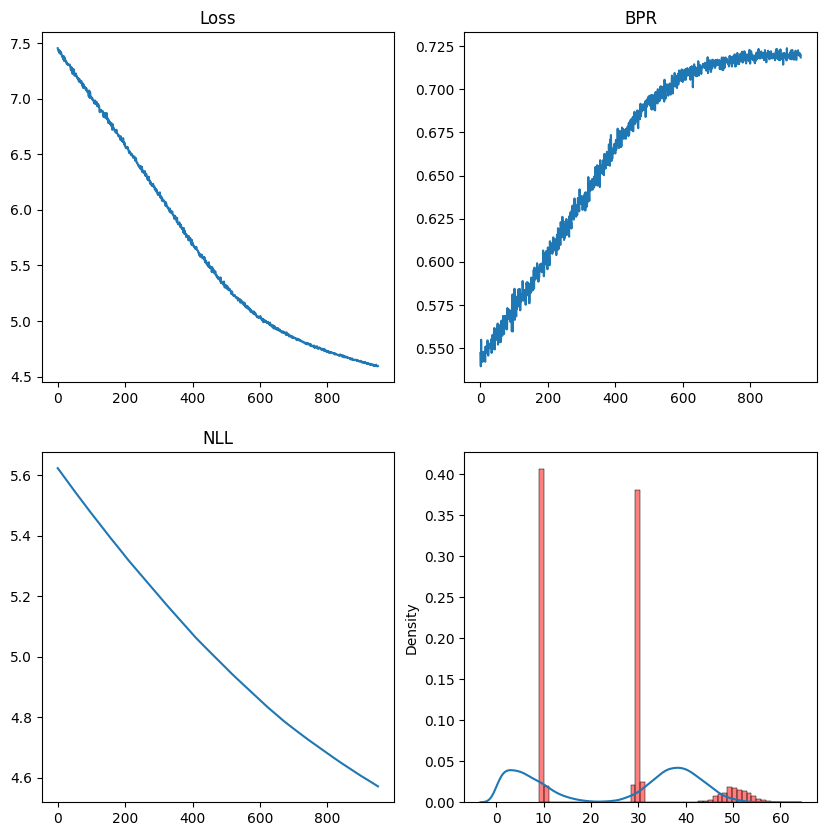

Init 13 BPR: 0.8711054742217769
/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw1_nw1_ss0.001_sig0.05_init13


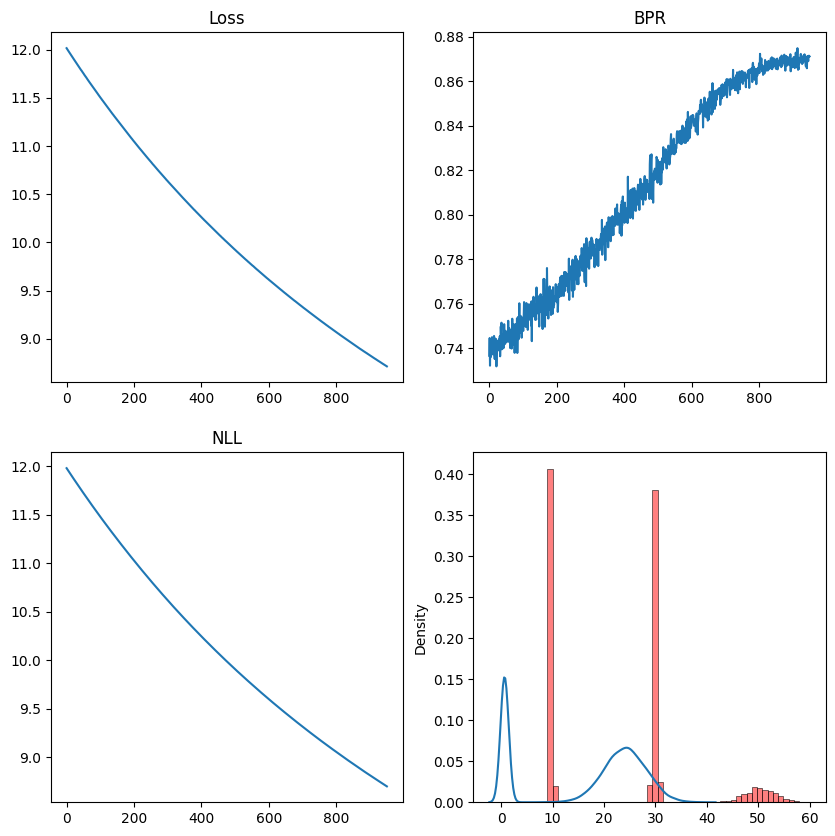

Init 16 BPR: 0.722611380547532
/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw20_nw1_ss0.001_sig0.05_init16


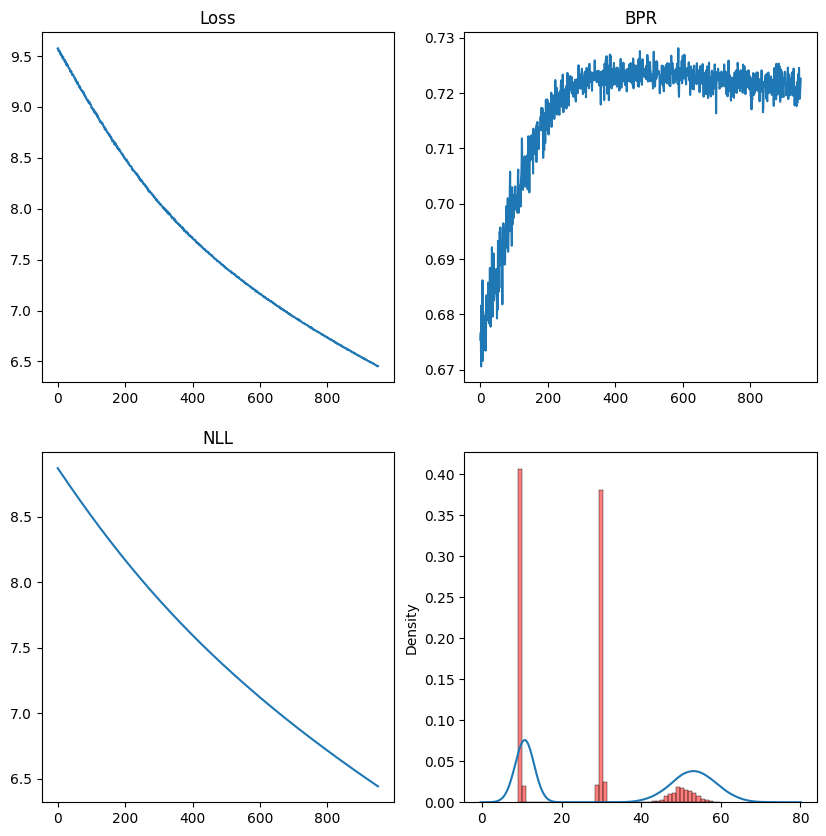

Init 3 BPR: 0.8102854353115694
/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw20_nw1_ss0.001_sig0.05_init3


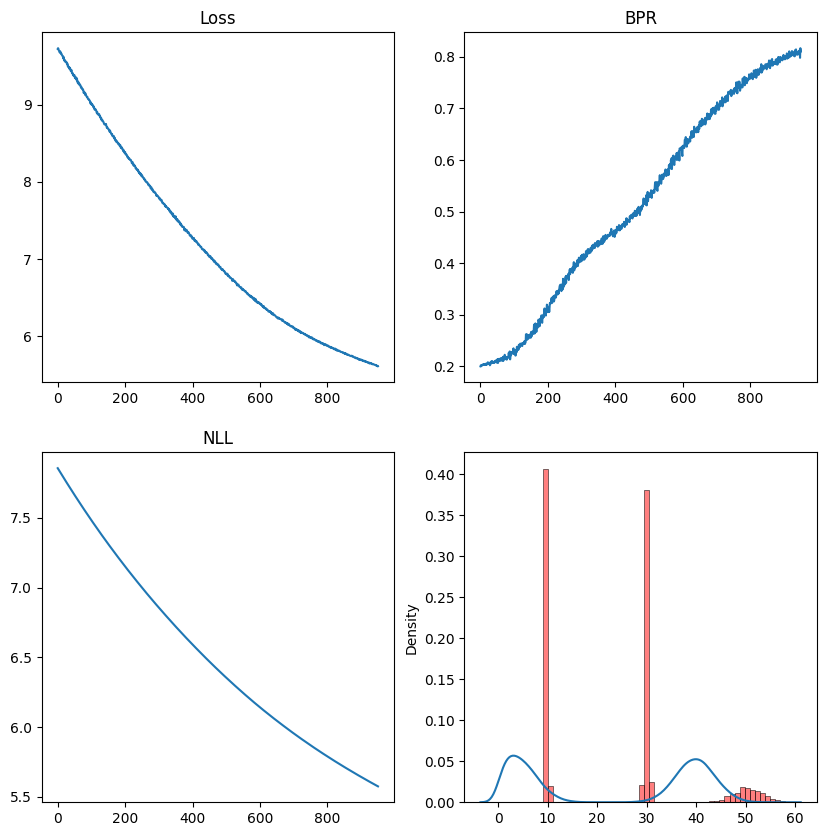

In [23]:
for init, bpr in both_bprs_by_init.items():
    if bpr<0.95 and bpr>0.71:
        print(f'Init {init} BPR: {bpr}')
        print(both_exp_by_init[init])
        exp = both_exp_by_init[init]
        losses = torch.load(exp + '/losses.pth')
        bprs = torch.load(exp + '/bprs.pth')
        nlls = torch.load(exp + '/nlls.pth')

        losses = np.array([loss.detach().numpy() for loss in losses])
        bprs = np.array([bpr.detach().numpy() for bpr in bprs])
        nlls = np.array([nll.detach().numpy() for nll in nlls])
        model = MixtureOfTruncNormModel(num_components=2, S=23)
        model = make_report(model, exp, train_y_TS,)

In [27]:
print(losses[-10:])
print(bprs[-10:])
print(nlls[-10:])

[5.6251923  5.62364692 5.62577295 5.62378371 5.61500967 5.6195668
 5.61576726 5.61156463 5.60695032 5.60857563]
[0.80406034 0.80529423 0.8064847  0.81068868 0.80645961 0.81147463
 0.81291973 0.79804468 0.81671265 0.81028544]
[5.5870484  5.58572165 5.58439452 5.5830679  5.58174265 5.58041529
 5.57908694 5.57776235 5.5764395  5.57512035]


In [15]:
for nll, bpr, exp in zip(nll_nlls_by_init.values(), nll_bprs_by_init.values(), nll_exp_by_init.values()):
    print(f'NLL: {nll}, BPR: {bpr}, Exp: {exp}')

NLL: -27680.57538404452, BPR: 0.5993958968436736, Exp: /cluster/tufts/hugheslab/kheuto01/synth_103050_20randinitidx_1000_comp2/bw0_nw1_ss0.5_init0
NLL: -24237.511552512304, BPR: 0.6856786869164668, Exp: /cluster/tufts/hugheslab/kheuto01/synth_103050_20randinitidx_1000_comp2/bw0_nw1_ss0.5_init1
NLL: -27299.23445400868, BPR: 0.5995411778011682, Exp: /cluster/tufts/hugheslab/kheuto01/synth_103050_20randinitidx_1000_comp2/bw0_nw1_ss0.5_init10
NLL: -40692.98178153909, BPR: 1.0, Exp: /cluster/tufts/hugheslab/kheuto01/synth_103050_20randinitidx_1000_comp2/bw0_nw1_ss0.5_init11
NLL: -24237.51799862297, BPR: 0.6945068050698363, Exp: /cluster/tufts/hugheslab/kheuto01/synth_103050_20randinitidx_1000_comp2/bw0_nw1_ss0.5_init12
NLL: -45789.4700655976, BPR: 0.4753387270048208, Exp: /cluster/tufts/hugheslab/kheuto01/synth_103050_20randinitidx_1000_comp2/bw0_nw1_ss0.5_init13
NLL: -40692.984195646466, BPR: 1.0, Exp: /cluster/tufts/hugheslab/kheuto01/synth_103050_20randinitidx_1000_comp2/bw0_nw1_ss0.5_in

In [ ]:
plt.plot(nll_bprs, nll_nlls, 'bo', label='Optimize NLL')
plt.plot(bpr_bprs, bpr_nlls, 'go', label='Optimize BPR')
plt.plot(both_bprs, both_nlls, 'ro', label='Optimize Both')
plt.xlabel('BPR')
plt.ylabel('Log Likelihood')
# set ylimits to -100000 to 0
#plt.ylim(-1100000, -20000)
# make y axis log scale even with negative values
plt.yscale('symlog', linthresh=1)
plt.title('Training Frontier')
plt.legend()
    

In [ ]:
nllslen(n)

In [10]:
bpr_exp_by_init

defaultdict(str,
            {0: '/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw1_nw0_ss0.1_sig0.01_init0',
             1: '/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw1_nw0_ss0.1_sig0.05_init1',
             10: '/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw1_nw0_ss0.1_sig0.01_init10',
             11: '/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw1_nw0_ss0.1_sig0.01_init11',
             12: '/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw1_nw0_ss0.1_sig0.01_init12',
             13: '/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw1_nw0_ss0.001_sig0.01_init13',
             14: '/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw1_nw0_ss0.1_sig0.01_init14',
             15: '/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw1_nw0_ss0.1_sig0.01_init15',
             16: '/cluster/tufts/hugheslab/kheuto01/didibreakitall_1000_comp2/bw1_nw0_ss0.1_sig0.01_init16',
    